# 8TB6G Exploratory Data Analysis

This document showcases a complete data analysis performed on a CAPP-HED-0.1 compliant dataset.

This notebook relies on the following libraries:
- capphed

The following set of conventions are followed throughout this notebook:

- A scope is defined as a grouping of text/code under a section.  For example "8TB6G Exploratory Data Analysis" defines the *global* scope.
- The cells containing shared usage of variables must be in a more specific scope than the *global*, unless the variables are defined with all UPPERCASE letters.
- Global scope variables shall not be redefined in any part of the document.

In [1]:
import warnings

warnings.filterwarnings(action="once")

## 1. Data Hierarchy
The data set contains 3 main root groups:

- `exp`: Holds the experimental data sets.
- `sim`: Simulation data sets relevant to the proceeding of experimental data within axion analysis context are stored here.
- `proc`: Any data under here are functions of `exp` and/or `sim`.

In [2]:
from pathlib import Path

DATAPATH = Path("~/Measurements/CAPP8TB6G/8TB6G-HE-P1/minimal.hednc").expanduser()
RUNNAME = "CD10-SUP6"
# DATAPATH = Path("minimal.hednc").expanduser()

Let's take a look at what's inside the `minimal.hednc`

In [3]:
import netCDF4 as nc4
from capphed.ncutils import nctraverse

ds = nc4.Dataset(DATAPATH)

display(vars(ds))
print("Root Groups:")
for path, item in nctraverse(ds):
    if item.name == "/":  # skip root
        continue
    if len(path.parents) >= 1:  # only show root groups
        break
    print(" " * 2, path / item.name)

ds.close()

{'title': 'he-p1-minimal',
 'source': 'CAPP8TB-6G',
 'comment': '',
 'history': '',
 'Conventions': 'CAPP-HED-0.1',
 'institution': 'IBS-CAPP'}

Root Groups:
   exp
   sim
   proc


In the root path, the main groups are `exp`, `sim` and `proc` as mentioned earlier.  Let's look under `exp`:

### 1.1 /exp

In [4]:
ds = nc4.Dataset(DATAPATH)

for path, item in nctraverse(ds):
    nparents = len(path.parents)
    if nparents < 1:
        continue
    if nparents >= 2:  # only show root groups
        break
    if isinstance(item, nc4.Group) and (
        not (item.name.startswith("_") or path.name.startswith("_"))
    ):
        print(" " * 2, path / item.name)

ds.close()

   exp/RunTable
   exp/NTMeas-BASELINE
   exp/CD10-SUP6


There are three subgroups under exp: RunTable, NTMeas-BASELINE and CD10-SUP6.  The RunTable is a HED table data for listing the names of the haloscope experiment runs the dataset contains.  `NTMeas-BASELINE` is a standard NTMeas measurement with an `mref` equal to BASELINE.  The CD10-SUP6 is the name of the only run this dataset contains, but to confirm that, we actually should take a look at the RunTable table.

#### 1.1.1 /exp/RunTable

In [5]:
ds = nc4.Dataset(DATAPATH)

rtgrp = ds["exp/RunTable"]
display(rtgrp)
ds.close()

<class 'netCDF4._netCDF4.Group'>
group /exp/RunTable:
    table_index: run_name
    dimensions(sizes): run_name(1)
    variables(dimensions): <class 'str'> run_name(run_name), int64 t_start(run_name), int64 t_end(run_name), int8 status(run_name)
    groups: 

We can see that this group defines 1 dimension, contains 4 variables and no subgroups.  Note that netCDF4 dimensions are simply labels for a certain index on variables, while variables are simply multi-dimensional arrays with dimensions defined for each of their index.

Note that RunTable group has an attribute named "table_index" which indicates that this data set is appropriate to be represented in a table.  I will open the dataset using `xarray` library, but immediately convert into a `pandas.DataFrame`.

In [6]:
import xarray as xr

_ds = xr.open_dataset(DATAPATH, group="exp/RunTable")
df = _ds.to_dataframe()
display(df)
_ds.close()

t_start t_end  status
run_name                       
CD10-SUP6     NaT   NaT       1

We can see that this dataset contains one run with the name "CD10-SUP6".  Now we programmatically confirmed the existence of exp/CD10-SUP6 as a valid axion dataset.  

Note that t_start and t_end columns are not provided for this particular dataset, but more complete datasets should provide it.  The `status` column holds an unsigned integer code indicating the status of the dataset: 1 means "ongoing" run, 0 means "finished" run.  This dataset is actually from a finished run, but it's not flagged as "finished" due to human error.  Since this is metadata for us, we can ignore this.

#### 1.1.2 /exp/NTMeas-BASELINE
This dataset contains the standard dataset NTMeas referring to *a noise temperature measurement using an internal noise source* done within the BASELINE state.  

Within the context of CAPP8TB-6G experiment's HE-P1 and HE-P2, BASELINE refers to the experimental state where the JPA is not pumped and it's bias current it's set to a value corresponding to ~-0.48 flux quantum which is well outside the experiment's frequency range.

This dataset has attributes conforming to CAPP-HED-0.1 standard which in turn borrows heavily from CF conventions.  This means we can use `xarray` library to open this dataset and access all the relevant information.

In [7]:
import xarray as xr

ntds = xr.open_dataset(DATAPATH, group="exp/NTMeas-BASELINE")

display(ntds)

<xarray.Dataset>
Dimensions:    (rep: 50, frequency: 87)
Coordinates:
    timestamp  (rep) datetime64[ns] ...
  * frequency  (frequency) float64 5.821e+09 5.822e+09 ... 5.958e+09 5.959e+09
  * rep        (rep) uint64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    tn         (rep, frequency) float64 ...
    tn_err     (rep, frequency) float64 ...
    gain       (rep, frequency) float64 ...
    gain_err   (rep, frequency) float64 ...
Attributes:
    comment:   
    title:     NTMEAS_CD10_SPEQAN_BINW15625_HIAVG_X10dB_HIREP.proc.nc
    source:    ckutlu@daq06:~/Measurements/211224/NTMEAS_CD10_SPEQAN_BINW1562...
    fitmodel:  bb+hp

We can see that this dataset contains 2 main dimensions: `rep` and `frequency`.  `rep` refers to each independent observation while the meaning of `frequency` should be clear.

We can see that the measurement was repeated 50 times within each noise temperature was estimated for 87 bins ranging from 5.821 GHz to 5.959 Hz.

Note that CAPP-HED strictly enforces the documentation of units, so if in doubt, you can check the unit of any variable:

In [8]:
_txt = "`{varname}` is in units of {unit}."

for varname in ["frequency", "rep", "tn", "gain"]:
    try:
        units = getattr(ntds, varname).attrs["units"]
        print(_txt.format(varname=varname, unit=units))
    except KeyError:
        print(f"`{varname}` is unitless.")

# Note that 'rep' is unitless since its an integer representing number of iterations.

`frequency` is in units of Hz.
`rep` is unitless.
`tn` is in units of K.
`gain` is in units of W/W.


Here is a plot of the noise temperature data contained in the dataset.  Each color represents different `rep`.

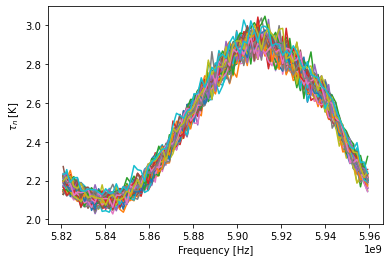

In [9]:
ntds.tn.plot.line(x="frequency", hue="rep", add_legend=False);

In [10]:
ntds.close()

#### 1.1.3 /exp/CD10-SUP6
This is an axion data set with the name CD10-SUP6.  As we saw in the RunTable, this is the only axion data set contained within this file.  Let's take a look at the groups under it:

In [11]:
ds = nc4.Dataset(DATAPATH)

for path, item in nctraverse(ds["exp/CD10-SUP6"], include_self=False):
    nparents = len(path.parents)
    if isinstance(item, nc4.Group):
        print(" " * 2, path / item.name)

ds.close()

   RunStepTable
   MeasTable
   StateTable
   ExpState
   CavityState
   JPAState
   SPar1Spect-WO-BASELINE
   SPar1Spect-CO-BASELINE
   SPar1Spect-BO-BASELINE
   SPar1Spect-BO-BASELINE-WIDE
   SPar1Spect-BO-ACTIVE
   PowSpect-BASELINE-ALT
   PowSpect-QACTIVE-ALT
   PowSpect-BASELINE
   PowSpect-QACTIVE
   PowSpect-QACTIVE-MARKER
   PowSpect-QACTIVE-MAXHOLD
   TimeStats
   AuxTable


We can see there are quite a bit of groups.  To get an overall understanding of an axion run, the first things we should look at are the tables.  Here is a quick way to figure out which groups contain tabular data for CAPP-HED compliant datasets:

In [12]:
ds = nc4.Dataset(DATAPATH)

for path, item in nctraverse(ds["exp/CD10-SUP6"], include_self=False):
    nparents = len(path.parents)
    if isinstance(item, nc4.Group):
        try:
            table_index = item.table_index
        except AttributeError:
            continue
        print(" " * 2, path / item.name)

ds.close()

   RunStepTable
   MeasTable
   StateTable
   ExpState
   CavityState
   JPAState
   TimeStats
   AuxTable


We will examine the tables and the data later in the document.

### 1.2 /sim

This namespace is reserved for later use.

### 1.3 /proc
This section is to hold processed data for easier access.

In [13]:
ds = nc4.Dataset(DATAPATH)

for path, item in nctraverse(ds["proc"], include_self=False):
    nparents = len(path.parents)
    if isinstance(item, nc4.Group):
        print(" " * 2, path / item.name)

ds.close()

   CD10-SUP6
   CD10-SUP6/RunNT


For the minimal dataset we only have one preprocessed data belonging to CD10-SUP6.
The data set is a RunNT type dataset.  We can just open it with xarray and see:

In [14]:
import xarray as xr

ds = xr.open_dataset(DATAPATH, group=f"proc/{RUNNAME}/RunNT")
display(ds)

ds.close()

<xarray.Dataset>
Dimensions:     (runstep: 19, dnu: 201)
Coordinates:
    fbin        (runstep, dnu) float64 ...
  * runstep     (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * dnu         (dnu) float64 -1e+06 -9.9e+05 -9.8e+05 ... 9.8e+05 9.9e+05 1e+06
    frequency   (runstep, dnu) float64 ...
Data variables:
    tn          (runstep, dnu) float64 ...
    tn_err      (runstep, dnu) float64 ...
    tn_alt      (runstep, dnu) float64 ...
    tn_alt_err  (runstep, dnu) float64 ...

Let's plot average tn values accross runsteps:

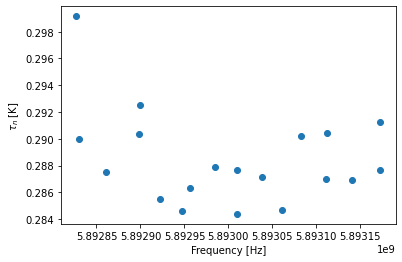

In [15]:
import xarray as xr

ds = xr.open_dataset(DATAPATH, group=f"proc/{RUNNAME}/RunNT")

ds.coords["fcenter"] = ds.fbin.median(dim="dnu")
ds.fcenter.attrs = ds.fbin.attrs
ds.tn.sel(dnu=slice(-50e3, 50e3)).mean(dim="dnu", keep_attrs=True).plot(
    x="fcenter", marker="o", linestyle=""
)

ds.close()

We will return to this during the actual analysis.

## 2. Run Data
The contents of each run data set is as follows with related descriptions:

    RunStepTable(runstep):  Tabular data containing information regarding start and finish times.  May contain culdaq references.
    MeasTable(id):  Tabular data containing information regarding which measurement is done when in a time ordered fashion.
    StateTable(id):  Tabular data where columns are ids for foreign tables of JPAState, CavityState and ExpState.
    ExpState(id):  Tabular data relating exp_state_id from StateTable to the name of the experimental state and its description.
    CavityState(id):  Tabular data for relating cav_state_id from StateTable.  Holds cavity frequency, beta (if available) and qfactor information.
    JPAState(id):  Tabular data for relating jpa_state_id from StateTable.  Holds state variables ib, fp, pp; along with estimated quantities det, fr0, bw0, flux, g1.
    SPar1Spect-WO-BASELINE(runstep, frequency, rep):  S measurement performed in WO path at BASELINE mode.
    SPar1Spect-CO-BASELINE(runstep, frequency, rep):  S measurement performed in CO path at BASELINE mode.
    SPar1Spect-BO-BASELINE(runstep, frequency, rep):  S measurement performed in BO path at BASELINE mode.
    SPar1Spect-BO-BASELINE-WIDE(runstep, frequency, rep):  
    SPar1Spect-BO-ACTIVE(runstep, frequency, rep):
    PowSpect-BASELINE-ALT(runstep, frequency, rep):
    PowSpect-QACTIVE-ALT(runstep, frequency, rep)
    PowSpect-BASELINE(runstep, frequency, rep):
    PowSpect-QACTIVE(runstep, frequency, rep):
    PowSpect-QACTIVE-MARKER(runstep, frequency(1), rep):  Power spectrum measurement at marker frequency(ies)
    PowSpect-QACTIVE-MAXHOLD(runstep, frequency, rep):
    TimeStats(runstep):  Time statistics for sequences during data taking.
    AuxTable(runstep, rep):  Temperature and magnetic field data.
    



The first 6 groups, which are mainly tabular information, will be read altogether within a "master table".

### 2.1 Measurement Master Table
We may read all the relevant tabular information into one big pandas DataFrame.  We can extract whatever we need from it using DataFrame operations afterwards.

In [16]:
from typing import Sequence

import pandas as pd
import xarray as xr


def _todf(fname, grp):
    ds = xr.open_dataset(fname, group=grp)
    df = ds.to_dataframe()
    ds.close()
    return df


def get_master_table(fname: str, run_name: str, exclude: Sequence[str] = ()):
    rgloc = f"exp/{run_name}"
    meas_t = _todf(fname, f"{rgloc}/MeasTable")
    state_t = _todf(fname, f"{rgloc}/StateTable")
    jpa_t = _todf(fname, f"{rgloc}/JPAState")
    exp_t = _todf(fname, f"{rgloc}/ExpState")
    cav_t = _todf(fname, f"{rgloc}/CavityState")

    grandstate: pd.DataFrame = (
        state_t.join(jpa_t, on="jpa_state_id")
        .join(exp_t, on="exp_state_id")
        .join(cav_t, on="cavity_state_id")
    )

    grandmeas = meas_t.join(
        grandstate.rename({"name": "mode"}, axis="columns"), on="state_id"
    )
    df: pd.DataFrame = grandmeas.set_index(
        ["runstep", "mode", "type", "mref"], drop=True
    )
    df.drop(columns=exclude, inplace=True, errors="ignore")
    return df


masterdf = get_master_table(DATAPATH, RUNNAME)

display(masterdf)

name  \
runstep mode     type       mref                                            
0       BASELINE SPar1Spect WO-BASELINE            SPar1Spect-WO-BASELINE   
                            CO-BASELINE            SPar1Spect-CO-BASELINE   
                            BO-BASELINE-WIDE  SPar1Spect-BO-BASELINE-WIDE   
                            BO-BASELINE            SPar1Spect-BO-BASELINE   
                 PowSpect   BASELINE-ALT            PowSpect-BASELINE-ALT   
...                                                                   ...   
18      ACTIVE   SPar1Spect BO-ACTIVE                SPar1Spect-BO-ACTIVE   
        QACTIVE  PowSpect   QACTIVE-ALT              PowSpect-QACTIVE-ALT   
                            QACTIVE                      PowSpect-QACTIVE   
                            QACTIVE-MAXHOLD      PowSpect-QACTIVE-MAXHOLD   
                            QACTIVE-MARKER        PowSpect-QACTIVE-MARKER   

                                              state_id timestamp  \
runstep mode     type       mref                                   
0       BASELINE SPar1Spect WO-BASELINE              0       NaT   
                            CO-BASELINE              0       NaT   
                            BO-BASELINE-WIDE         0       NaT   
                            BO-BASELINE              0       NaT   
                 PowSpect   BASELINE-ALT             0       NaT   
...                                                ...       ...   
18      ACTIVE   SPar1Spect BO-ACTIVE               55       NaT   
        QACTIVE  PowSpect   QACTIVE-ALT             56       NaT   
                            QACTIVE                 56       NaT   
                            QACTIVE-MAXHOLD         56       NaT   
                            QACTIVE-MARKER          56       NaT   

                                              jpa_state_id  cavity_state_id  \
runstep mode     type       mref                                              
0       BASELINE SPar1Spect WO-BASELINE                  0                0   
                            CO-BASELINE                  0                0   
                            BO-BASELINE-WIDE             0                0   
                            BO-BASELINE                  0                0   
                 PowSpect   BASELINE-ALT                 0                0   
...                                                    ...              ...   
18      ACTIVE   SPar1Spect BO-ACTIVE                   37               18   
        QACTIVE  PowSpect   QACTIVE-ALT                 37               18   
                            QACTIVE                     37               18   
                            QACTIVE-MAXHOLD             37               18   
                            QACTIVE-MARKER              37               18   

                                              exp_state_id        ib  \
runstep mode     type       mref                                       
0       BASELINE SPar1Spect WO-BASELINE                  0 -0.000142   
                            CO-BASELINE                  0 -0.000142   
                            BO-BASELINE-WIDE             0 -0.000142   
                            BO-BASELINE                  0 -0.000142   
                 PowSpect   BASELINE-ALT                 0 -0.000142   
...                                                    ...       ...   
18      ACTIVE   SPar1Spect BO-ACTIVE                   55 -0.000006   
        QACTIVE  PowSpect   QACTIVE-ALT                 56 -0.000006   
                            QACTIVE                     56 -0.000006   
                            QACTIVE-MAXHOLD             56 -0.000006   
                            QACTIVE-MARKER              56 -0.000006   

                                                        fp        pp  \
runstep mode     type       mref                                       
0       BASELINE SPar1Spect WO-BASELINE       1.178634e+10       NaN   
 

The current version of `capp8tb.py`(or the verbatim copies of it) does not support timestamping individual measurements, that is the reason why `timestamp` column is empty.

Using this table, we can get an idea on cavity frequency versus run step:

<AxesSubplot:xlabel='runstep', ylabel='$f_{0}$'>

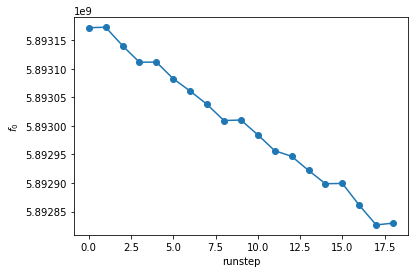

In [17]:
masterdf.groupby("runstep").head(1).reset_index().set_index("runstep").fcav.plot(
    marker="o", ylabel="$f_{0}$"
)

Or we can see the "peak JPA gain estimate (g1)" vs runstep:

<AxesSubplot:xlabel='runstep', ylabel='$G_1$ (dB)'>

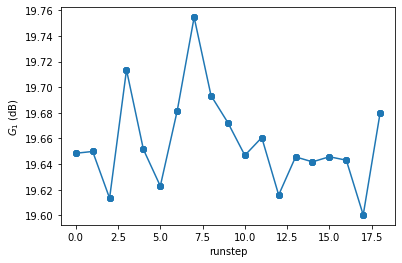

In [18]:
masterdf.loc[:, "QACTIVE", :, :].reset_index().set_index("runstep").g1.plot(
    marker="o", ylabel="$G_1$ (dB)"
)

I am leaving out different ways to seek information using the master table.

### 2.2 BASELINE Mode Data
This section includes data that are taken in the BASELINE mode.  This mode refers to the state where JPA flux is $\Phi \approx -0.48 \Phi_0$ and $ P_p = -\infty \mathrm{dBm}$ .

With the exception of SPar1Spect-BO-BASELINE-WIDE, all spectral data will be expected to have symmetry around some frequency $ f_{sc} $ (SC stands for Symmetry Center).  In CAPP8TB-6G, we choose JPA amplification center frequency($ f_p/2 $) to overlap with cavity center frequency ($ f_c $), estimated in-situ.  So the symmetry is twofold: due to cavity center frequency, and due to JPA's signal and idler amplification symmetry.  Note that symmetry due to cavity will be broken due to impedance environment, but the symmetry around $ f_p/2 $ will be mostly preserved.

We use $ f_p / 2 $ as $ f_{sc} $ since $ f_p $ has much lower uncertainty compared to $ f_c $.  Note that JPA transfer function will deviate from perfect $ f_p /2 $ symmetry due to finite gain and small nonlinearity effects.

In order to reflect the symmetry in the data, I will add a coordinate defined with $ \Delta \nu = f - f_{sc}$.

In [19]:
import numpy as np


def isclose(arr, axis, rtol=1e-05, atol=1e-08, equal_nan=False):
    tocomp = np.roll(arr, shift=1, axis=axis)
    comparison = np.isclose(arr, tocomp, rtol, atol, equal_nan)
    return comparison


def get_dataset(name, with_dnu=True):
    ds = xr.open_dataset(DATAPATH, group=f"exp/{RUNNAME}/{name}")
    if with_dnu:
        masterdf = get_master_table(DATAPATH, RUNNAME)
        fparr = (
            masterdf.loc[ds.runstep.data, "ACTIVE", :, :]
            .reset_index(["mode", "type", "mref"])
            .fp
        )
        fsc = (fparr / 2).rename("fsc").to_xarray()
        ds.coords["fsc"] = fsc
        ds.fsc.attrs = ds.fbin.attrs.copy()
        ds.fsc.attrs["long_name"] = "$f_{sc}$"
        ds.fsc.attrs["comment"] = "Equal to fp/2 where fp is JPA pump frequency."
        ds.coords["dnu"] = ds.fbin - fsc
        dnuattrs = ds.fbin.attrs.copy()
        dnuattrs["comment"] = "fbin - fsc."
        dnuattrs["long_name"] = "$\\Delta \\nu$"

        if ds.dnu.reduce(isclose, dim="runstep").all():
            # i.e. if all spectra are centered at fp/2
            # This means we can share dnu coordinate in all runsteps.
            # From xarray terms, this means the coordinate variable dnu
            # must have only one dimension, which is 'frequency'.
            # Here we are dropping the 'runstep' dimension from dnu
            ds.coords["dnu"] = (
                "frequency",
                ds.dnu.head(runstep=1).squeeze(dim="runstep", drop=True).data,
            )
            # IMPORTANT to assign as array, not dataarray, because it somehow affects fbin coordinate otherwise.

        ds.dnu.attrs = dnuattrs
    return ds


ds = get_dataset("SPar1Spect-WO-BASELINE")
display(ds)
ds.close()

<xarray.Dataset>
Dimensions:     (runstep: 19, frequency: 5001, rep: 1)
Coordinates:
  * runstep     (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fbin        (runstep, frequency) float64 ...
    timestamp   (runstep, rep) datetime64[ns] ...
    fsc         (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    dnu         (runstep, frequency) float64 -2.5e+06 -2.499e+06 ... 2.5e+06
Dimensions without coordinates: frequency, rep
Data variables:
    spar_mag    (runstep, rep, frequency) float64 ...
    spar_phase  (runstep, rep, frequency) float64 ...
    nobs        (runstep, rep) uint64 ...
    ifbw        (rep) float64 ...
    power       (rep) float64 ...
    spar_mag_l  (runstep, rep, frequency) float64 ...
Attributes:
    mref:     WO-BASELINE

#### 2.2.1 SPar1Spect-WO-BASELINE

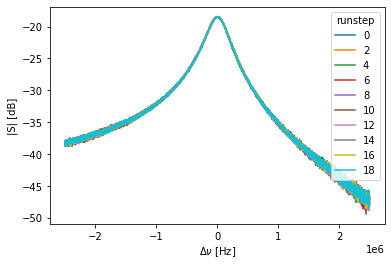

In [20]:
ds = get_dataset("SPar1Spect-WO-BASELINE")
every3rd = slice(0, None, 2)
ds.spar_mag.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

#### 2.2.2 SPar1Spect-CO-BASELINE

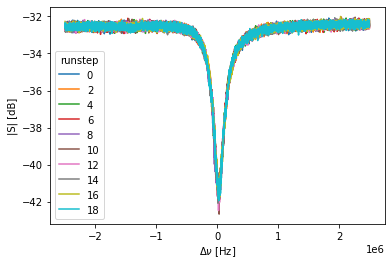

In [21]:
ds = get_dataset("SPar1Spect-CO-BASELINE")
every3rd = slice(0, None, 2)
ds.spar_mag.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

#### 2.2.3 SPar1Spect-BO-BASELINE

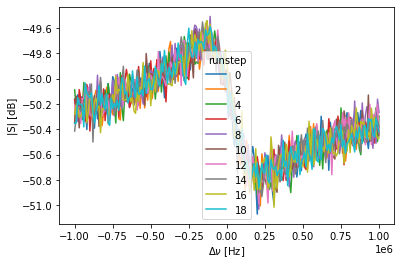

In [22]:
ds = get_dataset("SPar1Spect-BO-BASELINE")
every3rd = slice(0, None, 2)
ds.spar_mag.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

#### 2.2.4 SPar1Spect-BO-BASELINE-WIDE

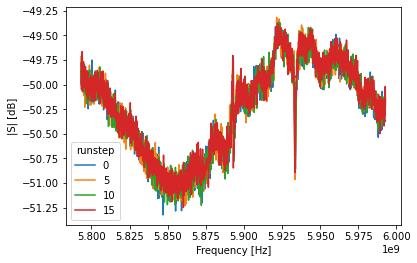

In [23]:
ds = get_dataset("SPar1Spect-BO-BASELINE-WIDE", with_dnu=False)
# every3rd = slice(0, None, 2)
ds.spar_mag.plot(x="fbin", hue="runstep");

There are two frequencies where sharp changes occur, let's check the first one:

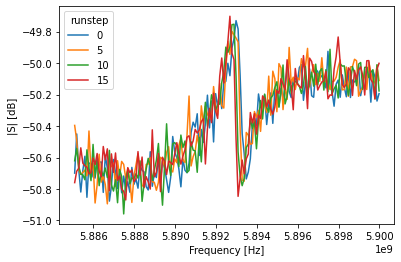

In [24]:
ds = get_dataset("SPar1Spect-BO-BASELINE-WIDE", with_dnu=False)
# every3rd = slice(0, None, 2)
if ds.fbin.reduce(isclose, dim="runstep").all():
    ds.coords["fbin"] = ds.fbin.head(runstep=1).squeeze(drop=True)
    ds = ds.swap_dims(frequency="fbin")


ds.spar_mag.sel(fbin=slice(5.885e9, 5.900e9)).plot(x="fbin", hue="runstep")
ds.close()

Judging by the shape, we can say that this is definitely similar to BO-BASELINE case, which is not surprising.

#### 2.2.5 PowSpect-BASELINE
A typical PowSpect dataset object looks like the following:

In [25]:
import numpy as np

ds = get_dataset("PowSpect-BASELINE")

display(ds)
ds.close()

<xarray.Dataset>
Dimensions:    (runstep: 19, frequency: 16001, rep: 1)
Coordinates:
  * runstep    (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fbin       (runstep, frequency) float64 ...
    timestamp  (runstep, rep) datetime64[ns] ...
    fsc        (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    dnu        (frequency) float64 -5e+05 -4.999e+05 ... 4.999e+05 5e+05
Dimensions without coordinates: frequency, rep
Data variables:
    power      (runstep, rep, frequency) float64 ...
    nobs       (runstep, rep) uint64 ...
    rbw        float64 ...
    nbw        float64 ...
    vbw        float64 ...
    swt        float64 ...
    detector   int16 ...
    window     float32 ...
    overlap    float64 ...
    power_w    (runstep, rep, frequency) float64 ...
Attributes:
    mref:          BASELINE
    dspcorr:       
    dspcorr_args:

Important variables are power and nobs, while most of the others are auxiliary variables related to the measurement instrument settings.

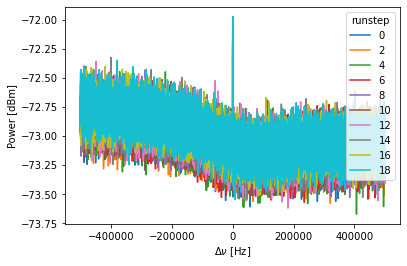

In [26]:
ds = get_dataset("PowSpect-BASELINE")
every3rd = slice(0, None, 2)
ds.power.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

#### 2.2.6 PowSpect-BASELINE-ALT
This is a power spectrum measurement done in parallel to the PowSpect-BASELINE using a second spectrum analyzer.  In the case of CAPP8TB-6G, this is a less efficient, but high reliability commercial spectrum analyzer from Keysight.

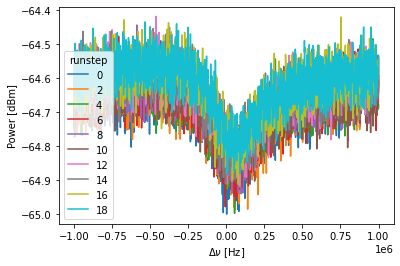

In [27]:
ds = get_dataset("PowSpect-BASELINE-ALT")
every3rd = slice(0, None, 2)
ds.power.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

Now, we know that PowSpect-BASELINE and PowSpect-BASELINE-ALT measure the same input power with minor differences in the two input path.  This is due to several effects combined of which the major ones are:
1. Frequency span difference:  The original measurement has 1 MHz span whereas BASELINE-ALT has 2 MHz span.  This creates a difference due to perception.
2. Noise bandwidth difference:  The original measurement has 62.5 Hz noise bandwidth whereas the second one has 964 Hz noise bandwidth.
3. Absolute power difference mostly due to the fact that the PowSpect-BASELINE has no absolute power calibration and therefore may be off by 3-4 dB.

We can correct for these effects and take a look again:

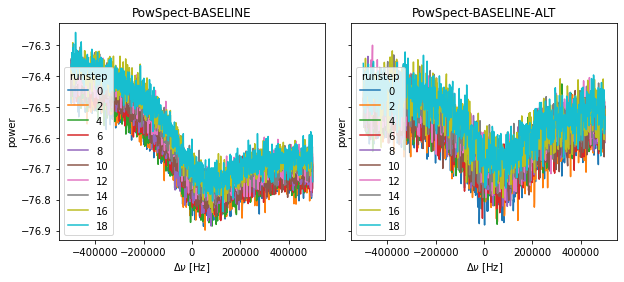

In [28]:
import matplotlib.pyplot as plt

ds1 = get_dataset("PowSpect-BASELINE").swap_dims(frequency="dnu")
ds2 = get_dataset("PowSpect-BASELINE-ALT").swap_dims(frequency="dnu")

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
ds1c = ds1.coarsen(dnu=15, boundary="trim").mean() - 3.6
# ds1c['power'] = 10*np.log10(ds1c.power_w) + 30
ds2c = (ds2 - 10 * np.log10(ds2.nbw / ds1.nbw)).sel(dnu=slice(-500e3, 500e3))

every3rd = slice(0, None, 2)
ds1c.power.sel(runstep=every3rd).plot(x="dnu", hue="runstep", ax=axs[0])
ds2c.power.sel(runstep=every3rd).plot(x="dnu", hue="runstep", ax=axs[1])

plt.subplots_adjust(wspace=0.1)
axs[0].set_title("PowSpect-BASELINE")
axs[1].set_title("PowSpect-BASELINE-ALT")

ds1.close()
ds2.close()

Now they look more or less similar. The difference is likely to be just a linear function of frequency due to the baseline calibration difference in instruments.

### 2.3 ACTIVE and QACTIVE Mode Data

ACTIVE mode corresponds to the case where JPA is tuned to the desired frequency and gain.  QACTIVE mode is essentially the same with ACTIVE but VNA power is ensured to be turned off.  Additionally, there may be fake axion signal present during QACTIVE mode.

#### 2.3.1 SPar1Spect-BO-ACTIVE

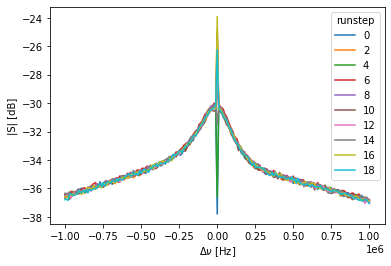

In [29]:
ds = get_dataset("SPar1Spect-BO-ACTIVE")
every3rd = slice(0, None, 2)
ds.spar_mag.sel(runstep=every3rd).plot(x="dnu", hue="runstep")
ds.close()

The sharp peak in the middle is due to the degenerate point where signal and idler signal interfere depending on the phase relation between the signal and pump frequency.  
At each sweep, the phase of the signal from the VNA will be different, hence the fluctuations.
From the perspective of the axion signal with an unknown phase with coherence time of 300 $\mu s$, the fluctuations due to the axion signal and its idler will be averaged out on the scale of averaging which is more than 1200s.

#### 2.3.2 PowSpect-QACTIVE

Number of reps:  5
Number of averages for the first rep:  17600

Spectrum after first rep for each runstep


<xarray.Dataset>
Dimensions:    (runstep: 19, frequency: 16001, rep: 5)
Coordinates:
  * runstep    (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fbin       (runstep, frequency) float64 ...
    timestamp  (runstep, rep) datetime64[ns] ...
    fsc        (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    dnu        (frequency) float64 -5e+05 -4.999e+05 ... 4.999e+05 5e+05
Dimensions without coordinates: frequency, rep
Data variables:
    power      (runstep, rep, frequency) float64 ...
    nobs       (runstep, rep) uint64 ...
    rbw        float64 ...
    nbw        float64 ...
    vbw        float64 ...
    swt        float64 ...
    detector   int16 ...
    window     float32 ...
    overlap    float64 ...
    power_w    (runstep, rep, frequency) float64 ...
Attributes:
    mref:          QACTIVE
    dspcorr_args:  
    dspcorr:       DSPTF211213

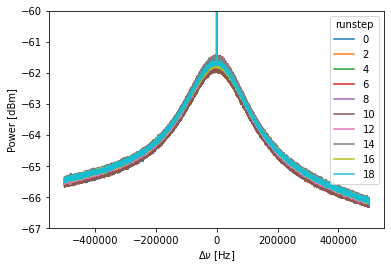

In [30]:
ds = get_dataset("PowSpect-QACTIVE")
every3rd = slice(0, None, 2)
print("Number of reps: ", ds.dims["rep"])
print("Number of averages for the first rep: ", ds.nobs.sel(rep=0).data[0])
print("\nSpectrum after first rep for each runstep")
ds.power.sel(runstep=every3rd, rep=0).plot(x="dnu", hue="runstep", ylim=(-67, -60))
display(ds)
ds.close()

Note that the peak in the middle in this case has a different interpretation than the case with VNA.  This is expected to be due to the downconversion of the pump signal.  It is not a requirement of JPA operation, and is expected to be due to an unwanted nonlinearity in the transfer function.

This should not be confused with IQ imbalance artifacts that spectrum analyzer's may have at their central bin.  The peak persists at the same frequency even if one tunes the spectrum analyzer center frequency to some offset from the peak location.

#### 2.3.3 PowSpect-QACTIVE-ALT

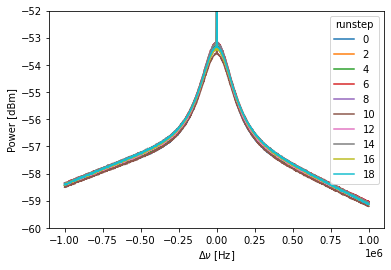

In [31]:
ds = get_dataset("PowSpect-QACTIVE-ALT")
every3rd = slice(0, None, 2)
ds.power.sel(runstep=every3rd).plot(x="dnu", hue="runstep", ylim=(-60, -52))
ds.close()

#### 2.3.5 PowSpect-QACTIVE-MAXHOLD
This data channel uses the same underlying spectrum data as PowSpect-QACTIVE, but instead of averaging individual spectra, we select the bin maximums in all the spectra.

This is mainly intended to be an auxiliary statistic to see if there was any intermittent external interference.

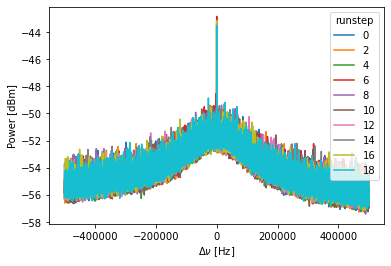

In [32]:
ds = get_dataset("PowSpect-QACTIVE-MAXHOLD")
every3rd = slice(0, None, 2)
ds.power.sel(runstep=every3rd, rep=0).plot(x="dnu", hue="runstep")
ds.close()

#### 2.3.6 PowSpect-QACTIVE-MARKER
This is a time domain measurement at a single frequency per runstep.  It is from the same underlying spectral data used to estimate PowSpect-QACTIVE.

One can use this dataset to test stochasticity of the power spectrum measurements.

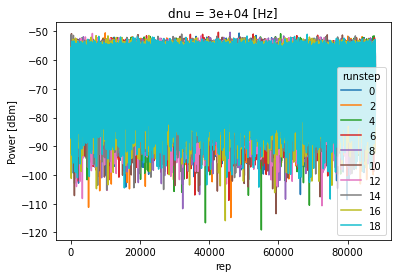

In [33]:
ds = get_dataset("PowSpect-QACTIVE-MARKER")
every3rd = slice(0, None, 2)
ds.power.sel(runstep=every3rd).plot(x="rep", hue="runstep")
ds.close()

### 2.4 Run Noise Temperature Data
The /proc/RunNT group contains precomputed values for noise temperature per runstep. 

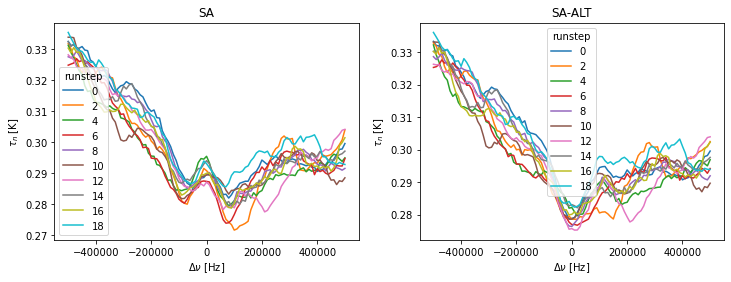

In [34]:
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(DATAPATH, group=f"proc/{RUNNAME}/RunNT")

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ds.tn.isel(runstep=slice(0, None, 2)).sel(dnu=slice(-500e3, 500e3)).plot(
    x="dnu", hue="runstep", ax=axs[0]
)
ds.tn_alt.isel(runstep=slice(0, None, 2)).sel(dnu=slice(-500e3, 500e3)).plot(
    x="dnu", hue="runstep", ax=axs[1]
)

axs[0].set_title("SA")
axs[1].set_title("SA-ALT")

ds.close()

One can see that the except for around the dnu=0, the values are pretty close by.  It is likely that the difference is due to a saturation effect either on the SA or SA-ALT instrument and not due to the JPA or the chain elements themselves.

It is known that the SA-ALT benefits from 10 dB more attenuation based on tests done after this data was taken.  The effect of a bit more attenuation on SA should be tested.

### 2.5 Other Data Sets

#### 2.5.1 AuxTable
Data set of temperatures, and magnetic field readings.

b_max_est:  Magnetic field estimation for the point where it is at its maximum, based on current measurement and conversion factor.
i_mag:  Measurement of the current supplied to the magnet.

In [35]:
ds = get_dataset("AuxTable", False)
display(ds)
ds.close()

<xarray.Dataset>
Dimensions:    (runstep: 19, rep: 2)
Coordinates:
  * runstep    (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Dimensions without coordinates: rep
Data variables:
    t_mc1      (runstep, rep) float64 ...
    t_mc2      (runstep, rep) float64 ...
    t_ns       (runstep, rep) float64 ...
    t_cav1     (runstep, rep) float64 ...
    t_cav2     (runstep, rep) float64 ...
    t_still    (runstep, rep) float64 ...
    t_4k       (runstep, rep) float64 ...
    t_50k      (runstep, rep) float64 ...
    b_max_est  (runstep, rep) float64 ...
    i_mag      (runstep, rep) float64 ...
Attributes:
    table_index:  runstep rep

#### 2.5.2 TimeStats
Some statistics for time spent at various steps of DAQ.

- t_axion:  Time spent on acquiring axion sensitive spectrum acquisition.
- t_step:  Time spent on completing one full step of DAQ.
- t_aux:  Time spent doing auxiliary measurements and related operations (database access vs).
- t_jpatun: Time spent on tuning the JPA.
- t_rfchar: Time spent on characterizing the RF chain.
- t_cavtun: Time spent on tuning the cavity.
- t_cavchar: Time spent on characterizing the cavity.

In [36]:
ds = get_dataset("TimeStats", False)
display(ds)
ds.close()

<xarray.Dataset>
Dimensions:    (runstep: 19)
Coordinates:
  * runstep    (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Data variables:
    t_axion    (runstep) float64 ...
    t_step     (runstep) float64 ...
    t_aux      (runstep) float64 ...
    t_jpatun   (runstep) float64 ...
    t_rfchar   (runstep) float64 ...
    t_cavtun   (runstep) float64 ...
    t_cavchar  (runstep) float64 ...
Attributes:
    table_index:  runstep

## 3. Analysis 

### 3.1 Extraction of Cavity Parameters
During the analysis, we will need cavity resonance frequency and coupling parameters.  We can extract this information from the S-parameter data taken with WO and CO paths.

#### 3.1.1 Preparations
Let's take a look at $\Delta \nu$ dimension of WO dataset.

In [37]:
ds = get_dataset("SPar1Spect-WO-BASELINE")
display(ds.dnu)
ds.close()

<xarray.DataArray 'dnu' (runstep: 19, frequency: 5001)>
array([[-2499905., -2498905., -2497905., ...,  2498095.,  2499095.,
         2500095.],
       [-2499927., -2498927., -2497927., ...,  2498073.,  2499073.,
         2500073.],
       [-2499984., -2498984., -2497984., ...,  2498016.,  2499016.,
         2500016.],
       ...,
       [-2499902., -2498902., -2497902., ...,  2498098.,  2499098.,
         2500098.],
       [-2499993., -2498993., -2497993., ...,  2498007.,  2499007.,
         2500007.],
       [-2499959., -2498959., -2497959., ...,  2498041.,  2499041.,
         2500041.]])
Coordinates:
  * runstep  (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fbin     (runstep, frequency) float64 ...
    fsc      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    dnu      (runstep, frequency) float64 -2.5e+06 -2.499e+06 ... 2.5e+06
Dimensions without coordinates: frequency
Attributes:
    units:         Hz
    long_name:     $\Delta \nu$
    cell_methods:  frequency: point
    comment:       fbin - fsc.

We notice that the dnu is not constant among runsteps, but changes roughly within ~100 Hz.  This is due to a minor bug in the control script.  The frequencies and measurement is still completely valid, just the center frequency of the spectrum is slightly different compared to $f_{sc}$.

We can confirm that the difference in frequencies is minimal simply by looking at a histogram of deviation from mean.

<>:5: DeprecationWarning: invalid escape sequence \D


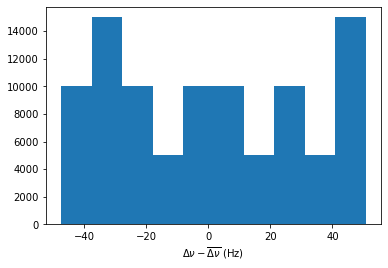

In [38]:
import matplotlib.pyplot as plt

ds = get_dataset("SPar1Spect-WO-BASELINE")
(ds.dnu - ds.dnu.mean(dim="runstep")).plot.hist()
plt.xlabel("$\Delta \\nu - \overline{\\Delta \\nu}$ (Hz)")
ds.close()

Since the deviation is not that much, and the SNR during WO measurement is large enough, we can simply interpolate all runstep data at a common $ \Delta \nu$ domain.

Span: 5000000.0
N bins: 5001
New dnu domain:  [-2500000. -2499000. -2498000. ...  2498000.  2499000.  2500000.]


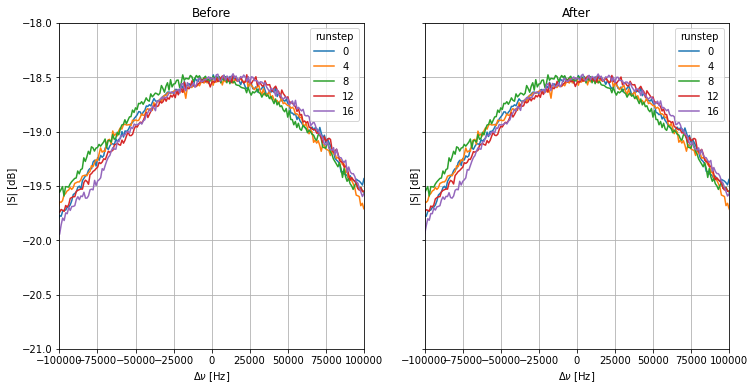

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

ds = get_dataset("SPar1Spect-WO-BASELINE")

ds.spar_mag.sel(runstep=slice(0, None, 4)).plot(
    x="dnu", hue="runstep", ax=ax1, xlim=(-100e3, 100e3), ylim=(-21, -18)
)

span = ds.dnu.isel(runstep=0, frequency=[0, -1]).dnu.diff(dim="frequency").data[0]
nbins = ds.dims["frequency"]
print(f"Span: {span}")
print(f"N bins: {nbins}")

domain = np.linspace(-span / 2, span / 2, nbins)
print("New dnu domain: ", domain)

for runstep, grp in ds[["spar_mag", "spar_phase"]].groupby("runstep"):
    grp_ = grp.swap_dims(frequency="dnu")
    interpd = grp_.interp(dnu=domain, kwargs=dict(fill_value="extrapolate"))
    ds[["spar_mag", "spar_phase"]].loc[dict(runstep=runstep)] = interpd.swap_dims(
        dnu="frequency"
    )

dnuattrs = ds.dnu.attrs
ds.coords["dnu"] = ("frequency", domain)
ds.dnu.attrs = dnuattrs

ds.spar_mag.sel(runstep=slice(0, None, 4)).plot(
    x="dnu", hue="runstep", ax=ax2, xlim=(-100e3, 100e3), ylim=(-21, -18)
)
ax1.grid()
ax2.grid()
ax1.set_title("Before")
ax2.set_title("After")

# Let's register this to the global namespace
DS_WO_BASELINE = ds
ds.close()  # data is still kept

You can see the plots show no difference between "Before" and "After" the $\Delta \nu$ domain change.  This is of course expected behavior, we just performed a sanity check.

The main reason to perform this is to keep a single $\Delta \nu$ array accross runsteps, which is much more manageable.  The procedure we need to do to perform fit accross runsteps also becomes simpler.

#### 3.1.2 Test Fit
Now that we restored some sanity to our dataset, let's move on with parameter extraction. 

For performing the fit on WO measurement, I will use the following function:

\begin{align}
f(\Delta \nu; \Delta f_c, b_c, a_0, a_1) &= \frac{a_0 + a_1 \Delta \nu }{1 + \left(\frac{2 (\Delta \nu - \Delta f_c )}{b_c}\right)^2} \\
\Delta f_c &=  f_c - f_{sc} \\
\Delta \nu &= f - f_{sc} \\
b_c &= \frac{f_c}{Q_L}
\end{align}

where $ f_c $ is cavity resonance frequency, $b_c$ is cavity bandwidth, $a_0$ is a parameter accounting for the frequency independent transmission line and coupling losses, $a_1$ is a parameter to account for the frequency dependent losses.

In [40]:
def lorentzian(dnu, dfc, bw):
    return (1 + (2 * (dnu - dfc) / bw) ** 2) ** (-1)


def spar_wo_fitfun(dnu, dfc, bw, a0, a1):
    return (a0 + a1 * dnu) * lorentzian(dnu, dfc, bw)

Before applying to the complete dataset, let's try it out on the first runstep of the dataset.

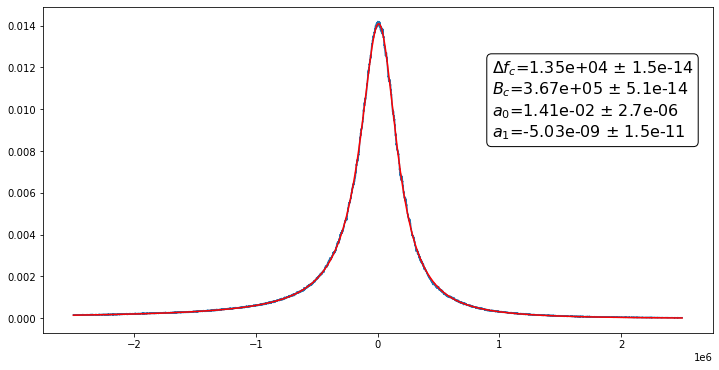

In [41]:
from scipy.optimize import curve_fit

ds = DS_WO_BASELINE.swap_dims(frequency="dnu").sel(dnu=slice(-5e6, 5e6))
dnu = ds.dnu.data
y = ds.spar_mag_l.sel(runstep=0, rep=0).data

p0_dct = {"dfc": 0, "bw": 400e3, "a0": 0.01, "a1": -5e-8}
bounds_dct = {
    "dfc": (-30e3, 30e3),
    "bw": (200e3, 600e3),
    "a0": (0.005, 0.05),
    "a1": (-9e-8, 9e-8),
}
fancy_names = {"dfc": "$\\Delta f_c$", "bw": "$B_c$", "a0": "$a_0$", "a1": "$a_1$"}


plt.figure(figsize=(12, 6))
plt.plot(dnu, y, label="data")

p0 = list(p0_dct.values())
bounds = bounds = list(zip(*bounds_dct.values()))  # the way that scipy wants

popt, pcov = curve_fit(spar_wo_fitfun, dnu, y, p0=p0, bounds=bounds)

pars = dict(zip(p0_dct.keys(), popt))
perrs = dict(zip(p0_dct.keys(), np.sqrt(np.diag(pcov))))
pars_txt = ", ".join([f"{name}={value:.3e}" for name, value in pars.items()])

plt.plot(dnu, spar_wo_fitfun(dnu, *popt), "r-", label=f"fit: {pars_txt}")


text = "\n".join(
    [
        f"{fancy_names[k]}={val:.2e} $\\pm$ {err:.1e}"
        for k, (val, err) in zip(pars.keys(), zip(pars.values(), perrs.values()))
    ]
)

plt.annotate(
    text,
    (0.67, 0.6),
    xycoords="axes fraction",
    fontsize=16,
    bbox=dict(fc="white", boxstyle="round"),
);

$\Delta f_c$ and $B_c$ are in Hz whereas the other two parameters are unitless (W/W).

#### 3.1.3 Batch Fit
Now that we know our cavity parameters does not wildly fluctuate, nor the coupling change wildly between runs.  We can embed this knowledge into the analysis _by assuming bounds and initial guess to be the same accross all runsteps_. 

In [42]:
WO_FIT_P0 = {"dfc": 0, "bw": 400e3, "a0": 0.01, "a1": -5e-8}
WO_FIT_BOUNDS = {
    "dfc": (-30e3, 30e3),
    "bw": (200e3, 600e3),
    "a0": (0.005, 0.05),
    "a1": (-9e-8, 9e-8),
}

With this at hand, parameter extraction is almost effortless:

In [43]:
ds = DS_WO_BASELINE.swap_dims(frequency="dnu")  # .sel(dnu=slice(-0.5e6, 0.5e6))

# Convert fit arguments
p0 = list(p0_dct.values())
bounds = bounds = list(zip(*bounds_dct.values()))  # the way that scipy wants

dsfit = ds.spar_mag_l.curvefit(
    "dnu", spar_wo_fitfun, p0=WO_FIT_P0, bounds=WO_FIT_BOUNDS
)
dsfit.runstep.attrs = ds.runstep.attrs.copy()
dsfit.timestamp.attrs = ds.timestamp.attrs.copy()
dsfit.fsc.attrs = ds.fsc.attrs.copy()
display(dsfit)

<xarray.Dataset>
Dimensions:                (runstep: 19, rep: 1, param: 4, cov_i: 4, cov_j: 4)
Coordinates:
  * runstep                (runstep) uint64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18
    timestamp              (runstep, rep) datetime64[ns] ...
    fsc                    (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09
  * param                  (param) <U3 'dfc' 'bw' 'a0' 'a1'
  * cov_i                  (cov_i) <U3 'dfc' 'bw' 'a0' 'a1'
  * cov_j                  (cov_j) <U3 'dfc' 'bw' 'a0' 'a1'
Dimensions without coordinates: rep
Data variables:
    curvefit_coefficients  (runstep, rep, param) float64 1.351e+04 ... -5.117...
    curvefit_covariance    (runstep, rep, cov_i, cov_j) float64 2.222e-28 ......

Let's extract the information we care from the dataset and throw away the rest:

In [44]:
params_of_interest = ["dfc", "bw"]
varname_map = {"dfc": "dfc", "bw": "bc"}
longname_map = {"dfc": "$\\Delta f_c$", "bw": "$B_c$"}
comment_map = {"dfc": "dfc = fc - fsc", "bw": "Cavity 3 dB bandwidth."}

da_d = {}

for param in params_of_interest:
    varname = varname_map[param]
    dspar = dsfit.sel(param=param, cov_i=param, cov_j=param).drop(
        ["timestamp", "param", "cov_i", "cov_j"]
    )
    coeffda = dspar.curvefit_coefficients
    coeffda.name = param
    coeffda.attrs["units"] = DS_WO_BASELINE.dnu.attrs["units"]
    coeffda.attrs["long_name"] = longname_map[param]
    coeffda.attrs["comment"] = comment_map[param]
    stdevda = xr.apply_ufunc(np.sqrt, dspar.curvefit_covariance)
    stdevda.name = f"{param}_err"
    stdevda.attrs["standard_name"] = "standard_error"
    stdevda.attrs["standard_name_mod_args"] = "statistical"

    coeffda.attrs["ancillary_variable"] = stdevda.name

    da_d[coeffda.name] = coeffda
    da_d[stdevda.name] = stdevda

ds = xr.Dataset(da_d)
ds["fcav"] = ds.dfc + ds.fsc
ds.fcav.attrs = ds.dfc.attrs
ds.fcav.attrs["long_name"] = "$f_c$"
ds.fcav.attrs["comment"] = "Cavity resonance frequency."
ds["q_l"] = ds.fcav / ds.bw
ds.q_l.attrs = {
    "long_name": "$Q_L$",
    "comment": "Loaded quality factory of the cavity.",
}
ds["q_l_err"] = ds.q_l * xr.apply_ufunc(
    np.sqrt, (ds.dfc_err / ds.fcav) ** 2 + (ds.bw_err / ds.bw) ** 2
)
ds.q_l_err.attrs = {
    k: v
    for k, v in ds.bw_err.attrs.items()
    if k in ["standard_name", "standard_name_mod_args"]
}
DS_WO_FIT = ds
display(DS_WO_FIT)

/tmp/ipykernel_2465636/804240069.py:10: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  dspar = dsfit.sel(param=param, cov_i=param, cov_j=param).drop(


<xarray.Dataset>
Dimensions:  (runstep: 19, rep: 1)
Coordinates:
  * runstep  (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fsc      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Dimensions without coordinates: rep
Data variables:
    dfc      (runstep, rep) float64 1.351e+04 1.192e+04 ... 1.424e+04 1.155e+04
    dfc_err  (runstep, rep) float64 1.491e-14 1.593e-14 ... 1.341e-14 1.419e-14
    bw       (runstep, rep) float64 3.674e+05 3.653e+05 ... 3.66e+05 3.655e+05
    bw_err   (runstep, rep) float64 5.149e-14 5.913e-14 ... 4.542e-14 5.298e-14
    fcav     (runstep, rep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    q_l      (runstep, rep) float64 1.604e+04 1.613e+04 ... 1.61e+04 1.612e+04
    q_l_err  (runstep, rep) float64 2.248e-15 2.611e-15 ... 1.998e-15 2.337e-15

As a quick test of tuning metric, let's check how $f_{cav}$ changes along runsteps:

Polynomial([ 5.89319156e+09, -1.97611141e+04], domain=[-1,  1], window=[-1,  1])

Residual std: 7939.476273134578 Hz


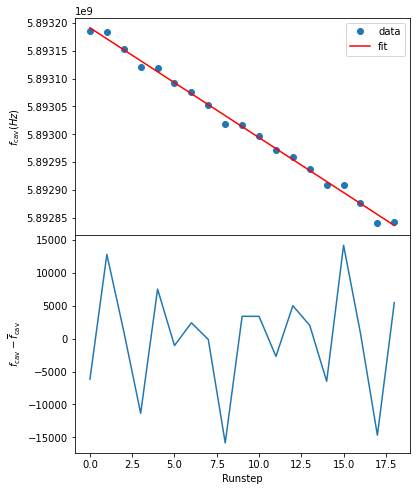

In [45]:
from numpy.polynomial import Polynomial

fit = DS_WO_FIT.fcav.squeeze(dim="rep").polyfit(dim="runstep", deg=1)
pobj = Polynomial(fit.polyfit_coefficients.sortby("degree"))
display(pobj)

rs = DS_WO_FIT.runstep
fcavfit = pobj(rs)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6, 8))
ax1.plot(rs, DS_WO_FIT.fcav, "o", label="data")
ax1.plot(rs, fcavfit, "-r", label="fit")
ax1.set_ylabel("$f_{\\mathrm{cav}} (Hz)$")

residual = DS_WO_FIT.fcav - fcavfit
print(f"Residual std: {residual.std().item()} Hz")
ax2.plot(rs, residual)
ax2.set_ylabel("$f_{\\mathrm{cav}} - \\overline{f}_{\\mathrm{cav}}$")
ax2.set_xlabel("Runstep")
fig.subplots_adjust(hspace=0)

ax1.legend()

Behavior of $f_{cav}$ can be compared with $f_{sc}$ which technically is the "in-situ" estimation for $f_{cav}$ using VNA functions.

Polynomial([ 5.89318043e+09, -1.98452632e+04], domain=[-1,  1], window=[-1,  1])

Residual std: 8345.953288207247 Hz


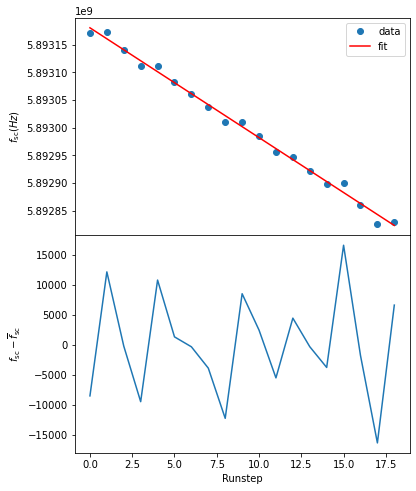

In [46]:
from numpy.polynomial import Polynomial

fit = DS_WO_FIT.fsc.polyfit(dim="runstep", deg=1)
pobj = Polynomial(fit.polyfit_coefficients.sortby("degree"))
display(pobj)

rs = DS_WO_FIT.runstep
fscfit = pobj(rs)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6, 8))
ax1.plot(rs, DS_WO_FIT.fsc, "o", label="data")
ax1.plot(rs, fscfit, "-r", label="fit")
ax1.set_ylabel("$f_{\\mathrm{sc}} (Hz)$")

residual = DS_WO_FIT.fsc - fscfit
print(f"Residual std: {residual.std().item()} Hz")
ax2.plot(rs, residual)
ax2.set_ylabel("$f_{\\mathrm{sc}} - \\overline{f}_{\\mathrm{sc}}$")
ax2.set_xlabel("Runstep")
fig.subplots_adjust(hspace=0)

ax1.legend()

We can also take a look at the cavity center frequency difference from the $f_{sc}$.

Text(0, 0.5, 'Count')

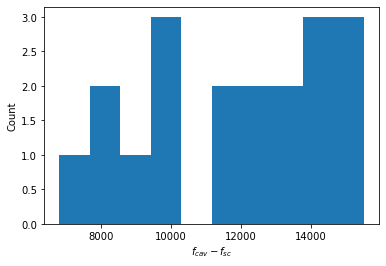

In [47]:
#(DS_WO_FIT.fcav - DS_WO_FIT.fsc).plot.hist()
DS_WO_FIT.dfc.plot.hist()
plt.xlabel("$f_{cav} - f_{sc}$")
plt.ylabel("Count")

This concludes our parameter extraction from SPar1Spect-WO-BASELINE data.  Now we can move on to estimating coupling.

#### 3.1.4 Coupling Coefficient ($\beta$) Estimation
For coupling estimation, I am gonna rely on $Q_0$ measurements rather than using the reflection data.  
$$
\beta = \frac{Q_0}{Q_L} - 1
$$

(DISCLAIMER) For the time being, I am using 4K measurements performed under 0 field.  It is expected that Q-factor will not change more than 1% under millikelvin temperatures and high fields.  Nevertheless, when millikelvin, high field measurements are available, they will be applied instead.

In [48]:
dsql = DS_WO_FIT[["fcav", "q_l", "q_l_err"]].squeeze().swap_dims(runstep='fcav')
dsq0 = xr.open_dataset(
    "/home/ckutlu/Work/CAPP8TB6G/8TB6G_Q0_S1.nc", group="QMeas-LT"
)[["q0", "q0_err"]].rename(frequency='fcav').interp_like(dsql)

b = dsq0.q0/dsql.q_l - 1
b_err = np.sqrt((dsql.q_l_err/dsql.q_l)**2 + (dsq0.q0_err/dsq0.q0)**2)*b
DS_CAV = xr.merge([DS_WO_FIT, xr.Dataset({'beta': b, "beta_err": b_err}).swap_dims(fcav='runstep').reset_coords('fcav')]).squeeze()
display(DS_CAV)

<xarray.Dataset>
Dimensions:   (runstep: 19)
Coordinates:
  * runstep   (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fsc       (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Data variables:
    dfc       (runstep) float64 1.351e+04 1.192e+04 ... 1.424e+04 1.155e+04
    dfc_err   (runstep) float64 1.491e-14 1.593e-14 ... 1.341e-14 1.419e-14
    bw        (runstep) float64 3.674e+05 3.653e+05 ... 3.66e+05 3.655e+05
    bw_err    (runstep) float64 5.149e-14 5.913e-14 ... 4.542e-14 5.298e-14
    fcav      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
    q_l       (runstep) float64 1.604e+04 1.613e+04 ... 1.61e+04 1.612e+04
    q_l_err   (runstep) float64 2.248e-15 2.611e-15 ... 1.998e-15 2.337e-15
    beta      (runstep) float64 1.719 1.704 1.721 1.726 ... 1.714 1.711 1.707
    beta_err  (runstep) float64 0.01021 0.01012 0.01022 ... 0.01016 0.01014

DS_CAV can be used to access all in-situ cavity measurements.

### 3.2 Central Bin Problem

One of the biggest problem affecting the dataset of CAPP8TB-6G experiment is the presence of sharp tones at $f_{sc}$ for all the obtained spectra.  The major additive factor for the excess power in that bin is the nonlinear downmixing of pump power.  The other factor is due to an imbalance at the spectrum analyzer's IQ sampling circuitry. 

Prior to data taking, it was established that the central excess power due to JPA pump is at least an order of magnitude larger than the factor due to IQ imbalance.

Below is a closer look at this unwanted tone:

In [49]:
from ipywidgets import interact

PS_QACTIVE = get_dataset("PowSpect-QACTIVE").swap_dims(frequency="dnu")


def _plot(runstep: int):
    pds = PS_QACTIVE.power
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    pds.sel(runstep=runstep).plot(x="dnu", hue="rep", ax=ax1, ylim=(-67, -47))
    pds.sel(runstep=runstep, dnu=slice(-0.5e3, 0.5e3)).plot(
        x="dnu", hue="rep", ax=ax2, linestyle="", marker="o", ylim=(-62, -61)
    )


rsrange = (PS_QACTIVE.runstep.min().item(), PS_QACTIVE.runstep.max().item())
wip = interact(_plot, runstep=rsrange)

/home/ckutlu/.local/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

The figure on the right shows us that not only the central bin, but also the nearby bins are affected.  We know that the transfer function for the RTSA is the fourier transform of rectangular window, i.e. looks like this:

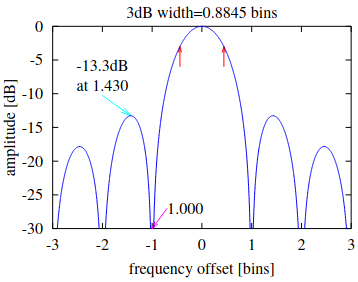

This means if we have a single tone interferer exactly centered at a bin, there should not be any leakage to the nearby bins (<<-30 dB from the plot).  This is clearly not the case for our measurement.

If we look closely, we can see that the leakage is asymmetric as well.  The existence of the leakage and its asymmetry tells us that there must be an internal frequency offset for the RTSA's reference clock.  Therefore the interferer tone is not at $\Delta \nu = 0$, but at some small offset $f_\epsilon$. 

Let's take a look at the spectrum obtained with the alternative SA:

In [50]:
from ipywidgets import interact

PS_QACTIVE_ALT = get_dataset("PowSpect-QACTIVE-ALT").swap_dims(frequency="dnu")


def _plot(runstep: int):
    pds = PS_QACTIVE_ALT.power
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    pds.sel(runstep=runstep).plot(x="dnu", hue="rep", ax=ax1, ylim=(-60, -50))
    pds.sel(runstep=runstep, dnu=slice(-5e3, 5e3)).plot(
        x="dnu", hue="rep", ax=ax2, linestyle="", marker="o", ylim=(-53.5, -52.1)
    )


rsrange = (PS_QACTIVE.runstep.min().item(), PS_QACTIVE.runstep.max().item())
wip = interact(_plot, runstep=rsrange)

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

It is clear that the alternative SA path does not have the asymmetry but still the leakage.  The reason why there is no asymmetry but leakage is because the SA-ALT uses a non-rectangular window which has non-zero leakage for signals with exact multiples of bin width.

Going back to our original data, PowSpect-QACTIVE, we may try doing a fit to obtain the $f_\epsilon$.  Note that the fit model should include an additive component due to an LO leakage from the SA $\Delta \nu=0$ as well.

#### 3.2.1 LO Leakage
LO frequency can leak due to small imbalance in IQ paths inside the hardware.  In commercial analyzers, this is usually corrected in preprocessing stage.  In the RTSA implementation at CAPP8TB this was left to the experimental analysis stage.
In order to figure the component of the peak due to IQ offset, I will give PowSpect-BASELINE data a closer look:

In [51]:
PS_BASELINE = get_dataset("PowSpect-BASELINE").swap_dims(frequency="dnu")


def _plot(runstep: int):
    pds = PS_BASELINE.power
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    pds.sel(runstep=runstep).plot(x="dnu", hue="rep", ax=ax1)  # , ylim=(-60, -50))
    pds.sel(runstep=runstep, dnu=slice(-5e3, 5e3)).plot(
        x="dnu", hue="rep", ax=ax2, linestyle="", marker="o", ylim=(-73.6, -72)
    )


rsrange = (PS_BASELINE.runstep.min().item(), PS_BASELINE.runstep.max().item())
wip = interact(_plot, runstep=rsrange)

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

I will use the following approach to obtain an estimate for the power of the IQ offset:
1. Remove center bin.
2. Apply SG-filter to obtain baseline.
3. Subtract the baseline from the unmodified dataset.
4. Record the power at the center bin as an estimate for the IQ offset power ($P_\epsilon$).

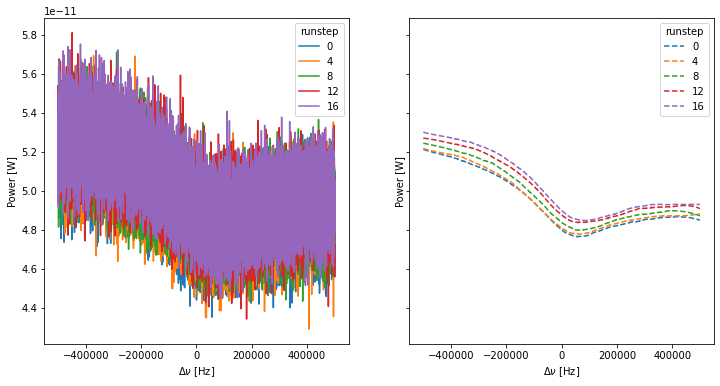

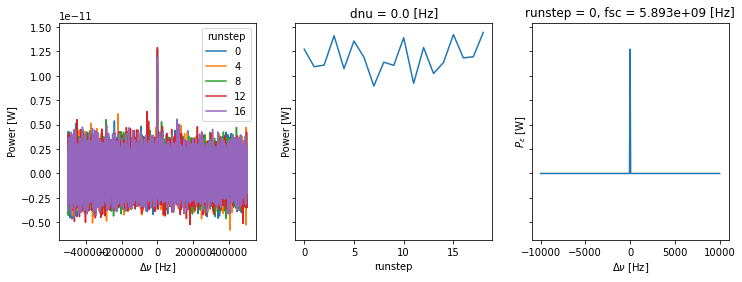

In [52]:
from xrscipy.signal import savgol_filter

pda = (
    PS_BASELINE.power_w.drop_sel(dnu=0)
    .reindex_like(PS_BASELINE)
    .interpolate_na(dim="dnu")
)
pda_f = savgol_filter(pda, dim="dnu", window_length=200e3, polyorder=3)
pda_f.attrs = pda.attrs.copy()


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
pda.sel(runstep=slice(0, None, 4)).plot(x="dnu", hue="runstep", ax=ax1)
pda_f.sel(runstep=slice(0, None, 4)).plot(
    x="dnu", hue="runstep", linestyle="--", ax=ax2
)

nobl = PS_BASELINE.power_w - pda_f
nobl.attrs = pda.attrs.copy()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))
nobl.sel(runstep=slice(0, None, 4)).plot(ax=ax1, x="dnu", hue="runstep")
nobl.sel(dnu=0).plot(ax=ax2, x="runstep")

PS_BASELINE["p_eps"] = (
    nobl.sel(dnu=[0]).mean(dim=["rep"]).reindex_like(nobl, fill_value=0)
)
PS_BASELINE.p_eps.attrs["long_name"] = "$P_\\epsilon$"
PS_BASELINE.p_eps.attrs["comment"] = "Power excess at the center bin due to IQ offset."
PS_BASELINE.p_eps.attrs["units"] = pda.attrs["units"]

PS_BASELINE.p_eps.sel(runstep=0, dnu=slice(-1e4, 1e4)).plot(ax=ax3)

You can see that the final estimation for the excess is $1.193 \times 10^{-11} \mathrm{W}$.  I assumed that the excess is constant across tuning steps.

Let's take a look at the PowSpect-QACTIVE with the IQ offset component removed:

In [53]:
from groundcontrol.util import watt2dbm


def _plot(runstep: int):
    pds_w = PS_QACTIVE.power_w - PS_BASELINE.p_eps
    pds = watt2dbm(pds_w)
    pds.attrs = PS_QACTIVE.power.attrs.copy()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    pds.sel(runstep=runstep).plot(x="dnu", hue="rep", ax=ax1, ylim=(-67, -47))
    pds.sel(runstep=runstep, dnu=slice(-0.5e3, 0.5e3)).plot(
        x="dnu", hue="rep", ax=ax2, linestyle="", marker="o", ylim=(-62, -61)
    )


rsrange = (PS_QACTIVE.runstep.min().item(), PS_QACTIVE.runstep.max().item())
wip = interact(_plot, runstep=rsrange)

/home/ckutlu/.local/lib/python3.9/site-packages/visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

There is no clear difference from the previous plots.  This is expected since the dominant cause of the excess power in the center bin was already established to be due to the JPA pump down mixing.

This section ends with the addition of PS_EPS, the LO leakage spectrum, to the global scope.

In [54]:
PS_EPS = PS_BASELINE.p_eps

#### 3.2.2 Pump Downmixing and LO Offset ($P^{\chi 0}$ and $f_\epsilon$)

Now we can do a fit on expected transfer function to obtain frequency error $f_\epsilon$.  To do this, I will use the following approach:

1. Remove of center bin and 3 bins from each side.
2. Apply SG filter to obtain baseline.
3. Remove baseline from the original spectrum.
4. Fit for the following function to obtain $f_\epsilon$:

\begin{align}
H(\Delta \nu; f_\epsilon) = C_H \left(\frac{sin(\pi (\Delta \nu + f_\epsilon)/f_{res})}{\pi (\Delta \nu + f_\epsilon)/f_{res}}\right)^2
\end{align}
where $f_{res}$ is the bin width of the spectrum (62.5 Hz).

We are claiming that there is an unknown offset between f and true f ($f'$), parameterized as $f' = f + f_\epsilon$.
Since $\Delta \nu = f - f_{sc}$,  we can write $\Delta \nu = f' - f_\epsilon - f_{sc}$. \
Rearranging that, we have:
\begin{align}
\Delta \nu' = \Delta \nu + f_\epsilon 
\end{align}

This is the reasoning why I chose the + sign above in the model.

In other words, $ f_\epsilon $ is the offset between SA local oscillator (LO) and $f_{sc}$:
\begin{align}
f_{LO} = f_{sc} + f_\epsilon
\end{align}

The model function will look like this:

In [55]:
def h_rect(dnu, feps, c_h, fres):
    x = (dnu + feps) / fres
    return c_h * np.sinc(x) ** 2


FRES = 62.5
c_h = 1

feps_norm = 1 / 5


def _plot(feps_norm: float, c_h: float):
    dnu_discrete = np.arange(-10, 11) * FRES
    dnu_cont = np.linspace(-10 * FRES, 10 * FRES, 10001)
    feps = feps_norm * FRES
    plt.semilogy(dnu_cont, h_rect(dnu_cont, feps, c_h, FRES))
    plt.semilogy(
        dnu_discrete,
        h_rect(dnu_discrete, feps, c_h, FRES),
        marker="o",
        color="r",
        linestyle="",
    )
    plt.ylim((1e-4, 1))
    plt.title(f"$f_\\epsilon $ = {feps:.1f} Hz")


normdnu = (-1, 1, 0.05)
interact(_plot, feps_norm=normdnu, c_h=(0.5, 1.5, 0.25));

interactive(children=(FloatSlider(value=0.0, description='feps_norm', max=1.0, min=-1.0, step=0.05), FloatSlid…

Now, let's see this in action by applying a fit on PowSpect-QACTIVE.  First let's check the correlation between center bin and nearby bins accross runsteps and repetitions.  I am only gonna check runsteps 0, 2, 4, 6, ... for simplicity:

In [56]:
runs = slice(0, None, 1)
fres = 62.5  # bin width

dnuselector = np.arange(-3, 4) * fres  # 7 bins around dnu=0

pda = (
    PS_QACTIVE.sel(runstep=runs)
    .power_w.drop_sel(dnu=dnuselector)
    .reindex_like(PS_QACTIVE)
    .interpolate_na(dim="dnu")
)
pda_f = savgol_filter(pda, dim="dnu", window_length=100e3, polyorder=5)
pda_f.attrs = pda.attrs.copy()

spind is runstep,rep


/home/ckutlu/.local/lib/python3.9/site-packages/xarray/core/dataset.py:6274: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/tmp/ipykernel_2465636/2468099993.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(spind, rotation=90);


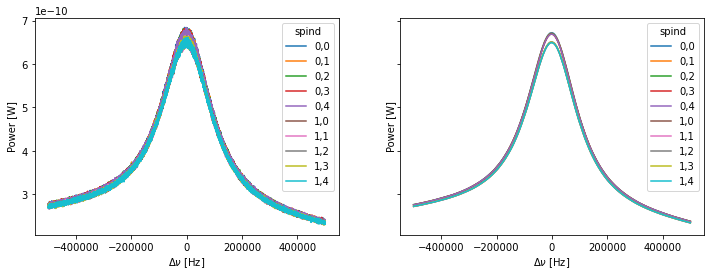

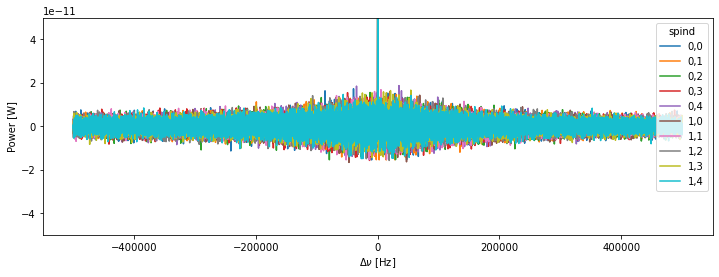

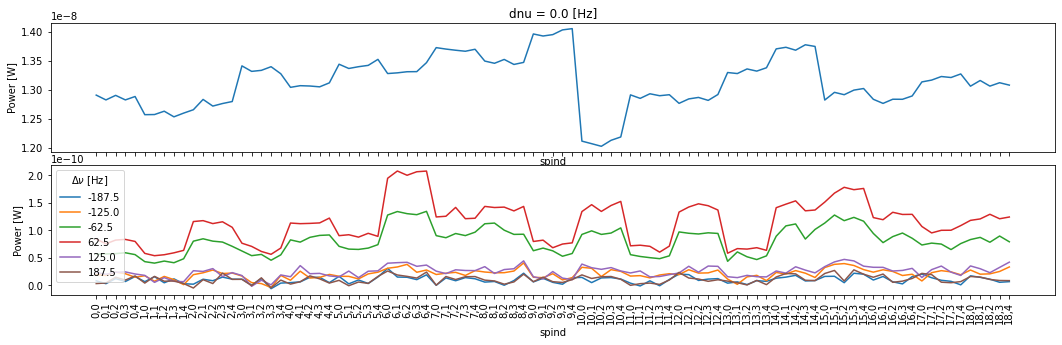

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)


def stackplot(da, ax):
    from itertools import product

    rs = da.runstep.data
    rep = da.rep.data
    spind = list(map(lambda dtpl: ",".join(map(str, dtpl)), product(rs, rep)))
    da.stack(spind=["runstep", "rep"]).reset_index("spind").assign_coords(
        spind=("spind", spind)
    ).plot(x="dnu", hue="spind", ax=ax)


print("spind is runstep,rep")
stackplot(pda.sel(runstep=[0, 1]), ax1)
stackplot(pda_f.sel(runstep=[0, 1]), ax2)

nobl = PS_QACTIVE.sel(runstep=runs).power_w - pda_f - PS_BASELINE.p_eps
nobl.attrs = pda.attrs.copy()

fig, ax = plt.subplots(figsize=(12, 4))
stackplot(nobl.isel(runstep=[0, 1]), ax=ax)
ylim = (
    nobl.quantile(0.01, interpolation="linear") * 5,
    nobl.quantile(0.99, interpolation="linear") * 5,
)
# ax.set_ylim(ylim)
ax.set_ylim((-5e-11, 5e-11))


def spindvspowplot(da, ax):
    from itertools import product

    rs = da.runstep.data
    rep = da.rep.data
    spind = list(map(lambda dtpl: ",".join(map(str, dtpl)), product(rs, rep)))
    da.stack(spind=["runstep", "rep"]).reset_index("spind").assign_coords(
        spind=("spind", spind)
    ).plot(x="spind", hue="dnu", ax=ax)
    return spind


fig, (ax1, ax2) = plt.subplots(figsize=(18, 5), nrows=2, sharex=True)
ax1.set_xlabel("")
spindvspowplot(nobl.sel(dnu=[0]), ax=ax1)
fig.subplots_adjust(hspace=0.1)
spind = spindvspowplot(nobl.sel(dnu=np.array([-3, -2, -1, 1, 2, 3]) * fres), ax=ax2)
ax2.set_xticklabels(spind, rotation=90);

We can see that the within a runstep, the unwanted tone is stationary.  On the other hand, we can see small changes from runstep to another.  Moreover, there is clear anti-correlation between $\Delta \nu \neq 0$ and $\Delta \nu = 0$ bins, indicating $f_{sc}$ dependence on $f_\epsilon$. 

Let's take a look at the pump power and central bin amplitude along runsteps:

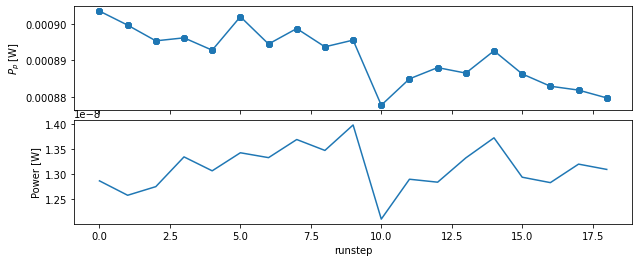

In [58]:
from groundcontrol.util import dbm2watt

masterdf = get_master_table(DATAPATH, RUNNAME)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)
masterdf.loc[:, "QACTIVE", :, :].reset_index().set_index("runstep").pp.apply(
    dbm2watt
).plot(marker="o", ylabel="$P_p$ [W]", ax=ax1)
nobl.sel(dnu=0).mean(dim="rep", keep_attrs=True).plot(x="runstep", ax=ax2)
ax1.set_xlabel("")
ax2.set_title("")

fig.subplots_adjust(hspace=0.1)

The correlation is clear if one sees the trend on runstep 10 and 13.  I will return to this correlation at the end of section 3.2.

I will use the following relation to show different components of the power spectrum:

\begin{align}
P_k = P^\epsilon_k + P^\chi_k + \overline{P}^{\mathrm{bl}}_k  + \eta_k + P^a_k\\
P^\epsilon_k = \delta_{k0} \overline{P}^\epsilon \\
P^\chi_k = P^{\chi 0}_k \left(\frac{sin(\pi (\Delta \nu_k + f_\epsilon)/f_{res})}{\pi (\Delta \nu_k + f_\epsilon)/f_{res}}\right)^2 \\
k = -N, -N+1, \dots, N
\end{align}
the $P^\epsilon_k$ term is the excess due to LO leakage,
the $P^\chi_k$ is the excess due to pump leakage,
the $\overline{P}^{\mathrm{bg}}_k$ term is the constant background term,
$\eta_k$ term is the stochastic term for the measurement (aka "error term")
and $P^a_k$ is the axion signal term.

Let's introduce i index to denote runsteps and rewrite the pump leakage term, absorbing the transfer function constant $C_H$ into a and b:

\begin{align}
P_{ik}^\chi = P_{k}^{\chi 0}\mathrm{sinc}^2\left(\frac{\Delta \nu_k + f_\epsilon}{f_{res}}\right) \\
\mathrm{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
\end{align}

To proceed with the fit, I will absorb $P_k^a$ inside the error term $\eta_k$.  Thus the data to perform the fit against is modeled by:
\begin{align}
y = P_{ik} - P_{k}^\epsilon - \overline{P}_{ik}^{\mathrm{bl}} = P_{ik}^\chi + \eta_k
\end{align}

(The DataArray containing this variable will be PS_NOBL1 inside the code.)

In [59]:
fres = 62.5  # bin width

dnuselector = np.arange(-3, 4) * fres  # 7 bins around dnu=0

pda = (
    PS_QACTIVE.power_w.drop_sel(dnu=dnuselector)
    .reindex_like(PS_QACTIVE)
    .interpolate_na(dim="dnu")
)
pda_f = savgol_filter(pda, dim="dnu", window_length=100e3, polyorder=5)
pda_f.attrs = pda.attrs.copy()

PS_NOBL1 = PS_QACTIVE.power_w - pda_f - PS_BASELINE.p_eps
PS_NOBL1.attrs = PS_QACTIVE.power_w.attrs.copy()
PS_NOBL1.attrs[
    "comment"
] = "$y = P_{ik} - P_{k}^\\epsilon - \\overline{P}_{ik}^{\\mathrm{bg}} = P_{ik}^\\chi + \\eta_k$"

In [60]:
yda = PS_NOBL1
ylim = (
    yda.quantile(0.01, interpolation="linear") * 5,
    yda.quantile(0.99, interpolation="linear") * 5,
)
span1 = 5e3
span2 = 1e3


def _plot(runstep: int):
    pds = yda
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    pds.sel(runstep=runstep, dnu=slice(-span1 / 2, span1 / 2)).plot(
        x="dnu", hue="rep", ax=ax1, ylim=ylim
    )
    pds.sel(runstep=runstep, dnu=slice(-span2 / 2, span2 / 2)).plot(
        x="dnu", hue="rep", ax=ax2, linestyle="", marker="o", ylim=ylim
    )
    ax1.set_title(f"SPAN: {span1:.1e}")
    ax2.set_title(f"SPAN: {span2:.1e}")


rsrange = (PS_QACTIVE.runstep.min().item(), PS_QACTIVE.runstep.max().item())
wip = interact(_plot, runstep=rsrange)

/home/ckutlu/.local/lib/python3.9/site-packages/xarray/core/dataset.py:6274: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

The expected power spectrum for a tone at $f = f_{LO} - f_{\epsilon i} $ is given as:

\begin{align}
P_{ik}^\chi = P_{i}^{\chi 0}\mathrm{sinc}^2\left(\frac{\Delta \nu_k + f_{\epsilon i}}{f_{res}}\right) \\
\mathrm{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
\end{align}

Here, $P^{\chi 0}_i$ is the power of the tone due to the downmixing of pump tone. 

In [61]:
def pump_leak(dnu, pchi0, feps):
    x = (dnu + feps) / fres
    return pchi0 * np.sinc(x) ** 2


PS_NOBL1_REPAVG = PS_NOBL1.mean(dim="rep", keep_attrs=True)
scaler = PS_NOBL1_REPAVG.sel(dnu=0).mean().item()

# P^{\chi 0} estimator

feps0 = 7
pchi00 = 1 / pump_leak(0, 1, feps0)

p0 = pchi00, feps0
bounds = [(pchi00 - abs(pchi00) * 0.1, -20), (pchi00 + abs(pchi00) * 10, 20)]


def _fitplot(nbins=7, runstep=0):
    fres = 62.5
    dnusel = np.arange(-(nbins // 2), nbins // 2 + 1) * fres
    yda = PS_NOBL1_REPAVG.sel(dnu=dnusel)
    # We need to prescale to O(1) for curve_fit
    # to work nicely.
    yval = yda.sel(runstep=runstep).data / scaler
    dnu = yda.dnu.data

    dnu_cont = np.linspace(dnu[0], dnu[-1], 1000)
    popt, pcov = curve_fit(pump_leak, dnu, yval, p0=p0, bounds=bounds, method="dogbox")
    popt[0] *= scaler
    pcov[0, :] *= scaler
    pcov[:, 0] *= scaler
    pstd = np.sqrt(pcov)

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.semilogy(dnu, yval * scaler, "o", markersize=8)
    ax.semilogy(dnu_cont, pump_leak(dnu_cont, *popt), "-r")

    powunit = yda.attrs["units"]
    funit = yda.dnu.attrs["units"]
    text = (
        f"$P^{{\\chi 0}}_{runstep}$={popt[0]:.2e} $\\pm$ {pstd[0,0]:.1e} {powunit}\n"
        f"$f_{{\\epsilon {runstep}}}$={popt[1]:.1f} $\\pm$ {pstd[1,1]:.1e} {funit}\n"
    )

    plt.annotate(
        text,
        (1, 1),
        xycoords="axes fraction",
        fontsize=14,
        ha="center",
        va="center",
        bbox=dict(fc="white", boxstyle="round"),
    )


rsrange = (PS_QACTIVE.runstep.min().item(), PS_QACTIVE.runstep.max().item())
interact(_fitplot, nbins=(5, 21, 2), runstep=rsrange);

interactive(children=(IntSlider(value=7, description='nbins', max=21, min=5, step=2), IntSlider(value=0, descr…

From the above plot, we can see that the fit is relatively successful.  We can also see that the error reduces as we incorporate more bins into fit, which increases the credibility of the result.

Now that we have the test fit working, let's apply to the whole dataset at once:

<xarray.Dataset>
Dimensions:    (runstep: 19)
Coordinates:
  * runstep    (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fsc        (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Data variables:
    pchi0      (runstep) float64 1.308e-08 1.274e-08 ... 1.347e-08 1.341e-08
    pchi0_err  (runstep) float64 3.752e-11 2.337e-11 ... 4.753e-11 6.256e-11
    feps       (runstep) float64 4.424 3.822 5.149 4.032 ... 5.409 4.868 5.27
    feps_err   (runstep) float64 0.3488 0.2588 0.4406 ... 0.4768 0.3894 0.4748

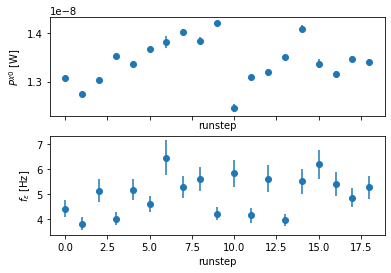

In [62]:
nbins = 5
fres = 62.5
da = PS_NOBL1_REPAVG.sel(dnu=slice(-nbins * fres // 2, fres * (nbins // 2 + 1)))


def pump_leak(dnu, pchi0, feps):
    x = (dnu + feps) / fres
    return pchi0 * np.sinc(x) ** 2


_feps0 = 7
p0 = {"pchi0": da.sel(dnu=0).mean().item() / pump_leak(0, 1, _feps0), "feps": _feps0}

# We need to apply prescaling to make curve_fit happy
#  this is simply a workaround for avoiding the numeric tolerance into the curve_fit
#  algorithm.
# Simplest choice of scaling is the initial guess of pchi0 parameter.
scaler = p0["pchi0"]

# Scaled da
da_s = da / scaler

# scaled parameter guess
p0["pchi0"] = 1

bounds = {"pchi0": [0.5, 2], "feps": [-15, 15]}

da_f = da_s.curvefit("dnu", pump_leak, p0=p0, bounds=bounds)
da_popt = da_f.curvefit_coefficients
da_pcov = da_f.curvefit_covariance
da_pcov.loc[{"cov_i": "pchi0"}] *= scaler
da_pcov.loc[{"cov_j": "pchi0"}] *= scaler
da_popt.loc[{"param": "pchi0"}] *= scaler


da_d = {}
for name in da_f.param.data:
    parval = da_popt.sel(param=name).drop_vars("param")
    parerr = np.sqrt(da_pcov.sel(cov_i=name, cov_j=name).drop_vars(["cov_i", "cov_j"]))
    parval.name = name
    parerr.name = f"{name}_err"

    da_d[parval.name] = parval
    da_d[parerr.name] = parerr

ds = xr.Dataset(da_d)
ds.pchi0.attrs = dict(
    da.attrs.copy(),
    long_name="$P^{\\chi 0}$",
    comment="Excess power due to JPA pump down-mixing.",
    ancillary_variable=ds.pchi0_err.name,
)
ds.pchi0_err.attrs = dict(
    units=da.attrs["units"],
    standard_name="standard_error",
    standard_name_mod_args="statistical",
)

ds.feps.attrs = dict(
    units=da.dnu.attrs["units"],
    long_name="$f_{\\epsilon}$",
    comment="Offset of LO from $f_{sc}$, i.e. $f_\\epsilon = f_{LO} - f_{sc}$",
)
ds.feps_err.attrs = dict(
    units=ds.feps.attrs["units"],
    standard_name="standard_error",
    standard_name_mod_args="statistical",
)

# Dataset for Pump Leak Fit1 (fit versus dnu)
DS_PLFIT1 = ds
display(DS_PLFIT1)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.errorbar(
    ds.runstep.data, ds.pchi0.data, yerr=ds.pchi0_err.data, marker="o", linestyle=""
)
ds.pchi0.plot(x="runstep", ax=ax1, marker="", linestyle="")  # for the labels
ax2.errorbar(
    ds.runstep.data, ds.feps.data, yerr=ds.feps_err.data, marker="o", linestyle=""
)
ds.feps.plot(x="runstep", ax=ax2, marker="", linestyle="")  # for the labels

Now we have estimates for $ P^{\chi 0}_i$ and $f_{\epsilon i}$.  Before moving on, I'd like to take a look at the relation between pump power and $P^{\chi 0}$:

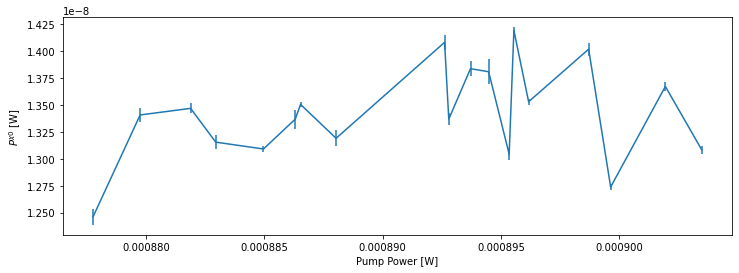

In [63]:
get_master_table(DATAPATH, RUNNAME)
masterdf = get_master_table(DATAPATH, RUNNAME)
PP_DA = dbm2watt(
    masterdf.loc[:, "QACTIVE", :, :]
    .reset_index()
    .set_index("runstep")
    .pp.drop_duplicates()
).to_xarray()
js = get_dataset("JPAState", False)
# assert js.pp.attrs['units'] == 'dBm'
PP_DA.attrs = dict(js.pp.attrs.copy(), units="W")

fig, ax = plt.subplots(figsize=(12, 4))
da = DS_PLFIT1.assign_coords(pp=PP_DA)
da_s = da.sortby("pp").swap_dims(runstep="pp")
plt.errorbar(da_s.pp, da_s.pchi0, yerr=da_s.pchi0_err)
da_s.pchi0.plot(marker="", linestyle="", ax=ax)

While we can see the correlation between pump power and the $P^{\chi 0}$, it is clear that there are more variables in play.  This is not surprising since the JPA amplification state is a function of 3 variables: pump power, pump frequency and flux.

I will not try to extract more information from $P^{\chi 0}$.

This section ends with having generated the DS_PLFIT1 dataset, containing the $P^{\chi 0}$ and the $f_\epsilon$ estimations.

Note that $f_\epsilon$ will be used to make a correction on $\Delta \nu$ prior to vertical combination.

### 3.3 Background Estimation
I will use the previously introduced model:

\begin{align}
P_{ik} = P^\epsilon_{i}\delta_{k0} + P^\chi_{ik} + \overline{P}^{\mathrm{bl}}_k  + \eta_k + P^a_{ik} \\
P_{ik}^\chi = P_{ik}^{\chi 0}\mathrm{sinc}^2\left(\frac{\Delta \nu_k + f_\epsilon}{f_{res}}\right) \\
\end{align}
where i index denotes runsteps,
k index denotes frequency bin in a single runstep,
$P^\epsilon_{i}\delta_{k0}$ denotes the excess power spectrum due to LO leakage,
$P^\chi_{ik}$ denotes the excess power spectrum due to pump,
$\overline{P}^{\mathrm{bl}}_k$ is the average baseline,
$P^a_{ik}$ is the axion spectrum,
and $\eta_k$ is the random variable associated with the baseline.

The complete background per spectra can be given as:
\begin{align}
P^{\mathrm{bg}} = P^\epsilon + P^\chi + \overline{P}^{\mathrm{bl}}
\end{align}


To estimate the baseline, I will rely on the fact that baseline is a smooth function of frequency that changes in a larger frequency scale than the axion lineshape.
Based on this assumption, a common choice is applying a Savitzky-Golay filter.

In [64]:
from matplotlib import ticker

PS_CHI = pump_leak(
    *map(
        lambda d: d.broadcast_like(PS_NOBL1_REPAVG),
        [PS_QACTIVE.dnu, DS_PLFIT1.pchi0, DS_PLFIT1.feps],
    )
)
PS_CHI.attrs = DS_PLFIT1.pchi0.attrs.copy()
PS_BLEA = PS_QACTIVE.power_w - PS_CHI - PS_EPS  # BL+Axion+Eta
PS_BLEA.attrs = dict(
    PS_QACTIVE.power_w.attrs, long_name="$\\overline{P}^{\\mathrm{bl}} + \\eta + P^a$"
)


def _plot(runstep):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    dnuslice = slice(-1e3, 1e3)
    selector = dict(runstep=runstep, dnu=dnuslice)

    pschi = PS_CHI.sel(selector)
    pseps = PS_EPS.sel(selector)
    pschi.plot(ax=ax1, marker="o", label=PS_CHI.attrs["long_name"])
    pseps.plot(ax=ax1, marker="x", label=PS_EPS.attrs["long_name"])

    rep = 0
    psqact = PS_QACTIVE.power_w.sel(**selector, rep=rep)
    psqact.plot(
        ax=ax1,
        x="dnu",
        hue="rep",
        label=f"$P(\\mathrm{{rep}}={rep})$",
    )
    ax1.set_ylabel("Power [W]")
    ax1.set_yscale("log")
    ax1.legend()

    psbla = PS_BLEA.sel(runstep=runstep, dnu=dnuslice)
    psbla.plot(
        x="dnu",
        hue="rep",
        ax=ax2,
    )
    ax2.set_ylabel("$\\overline{P}^{bl} + \\eta + P^a$ [W]")
    ax2.set_yscale("log")

    ylim1 = (pschi.min() * 0.5, psqact.quantile(0.99) * 2)
    ylim2 = (psbla.quantile(0.01) * 0.9, psbla.quantile(0.99) * 1.1)
    ax1.set_ylim(ylim1)
    ax2.set_ylim(ylim2)
    ax2.grid(which="both")
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5e-10))


interact(_plot, runstep=rsrange);

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

Seems like only the 3 bins from the center have the unwanted correlation left in them.  I will obtain the baseline after removing 3 bins at the center, and interpolate them:

In [65]:
NBINDROPD = 3
BL_FWINDOW = 50e3
BL_PORDER = 3

centbinslice = np.arange(-(NBINDROPD // 2), NBINDROPD // 2 + 1) * FRES
PS_BLEA_AVG = PS_BLEA.mean(dim="rep", keep_attrs=True)
dropped = (
    PS_BLEA_AVG.drop_sel(dnu=centbinslice)
    .reindex_like(PS_BLEA_AVG)
    .interpolate_na("dnu")
)
PS_BL = savgol_filter(dropped, BL_FWINDOW, polyorder=BL_PORDER, dim="dnu")
PS_BL.attrs = dict(PS_BLEA_AVG.attrs, long_name="$\\overline{P}^{bl}$")
PS_NOBL2 = (PS_BLEA_AVG - PS_BL).drop_sel(dnu=centbinslice)
PS_NOBL2.attrs = dict(PS_BLEA_AVG.attrs, long_name="$\\eta + P^a$")
DA_DELTA_P = (PS_BLEA_AVG / PS_BL - 1).drop_sel(dnu=centbinslice)
DA_DELTA_P.attrs = dict(
    long_name="$\\delta'$",
    comment="$\\delta' = (\\eta + P^a)/\\overline{P}^{\\mathrm{bl}} - 1$",
)


def _plot(runstep):
    fig = plt.figure(figsize=(20, 15))
    axs = []
    axs.append(fig.add_subplot(3, 3, 1))
    axs.append(fig.add_subplot(3, 3, 2))
    axs.append(fig.add_subplot(3, 3, 3))
    axs.append(fig.add_subplot(3, 3, 4, sharex=axs[0]))
    axs.append(fig.add_subplot(3, 3, 5, sharex=axs[1]))
    axs.append(fig.add_subplot(3, 3, 6, sharex=axs[2]))
    axs.append(fig.add_subplot(3, 3, 7, sharex=axs[0]))
    axs.append(fig.add_subplot(3, 3, 8, sharex=axs[1], sharey=axs[6]))
    axs.append(fig.add_subplot(3, 3, 9, sharex=axs[2], sharey=axs[6]))
    dnuwindows = (slice(None), slice(-300e3, -50e3), slice(-10e3, 10e3))
    for dnuwind, ax in zip(dnuwindows, axs[:3]):
        PS_BLEA_AVG.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, label=PS_BLEA_AVG.attrs["long_name"]
        )
        PS_BL.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, linestyle="--", linewidth=3, label=PS_BL.attrs["long_name"]
        )
        ax.set_ylabel("Power [W]")
        if ax is axs[0]:
            ax.legend()

    for dnuwind, ax in zip(dnuwindows, axs[3:6]):
        PS_NOBL2.sel(dnu=dnuwind, runstep=runstep).plot(ax=ax, marker="o", markersize=3)

    for dnuwind, ax in zip(dnuwindows, axs[6:]):
        DA_DELTA_P.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, marker="o", markersize=3
        )

    [axs[i].set_title("") for i in range(9) if i != 1]


interact(_plot, runstep=rsrange);

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

### 3.4 JPA Gain Factor Estimation
It is of extreme importance to define what "Gain" is.  For all intents and purposes in this document, gain of a component refers to its "in-situ" ratio of output power and input power.  The JPA Gain ($G_J$) refers to the "additional amplification" added in the receiver chain by activating the JPA with the baseline being provided by the HEMTs in operation.

In general, axion analysis does not rely heavily on the knowledge of gain.  This is simply due to the formulation of noise temperature as an input referred value.  Indeed, the reason for using noise temperature is so that we don't have to have the precise knowledge of gain.  In practice, gain is a less practical variable due to the small changes in the room temperature amplification path.  On the other hand, noise temperature would not be affected significantly even if an extra 3 dB attenuation is added in front of the SA.

For now, I am simply going to use the ratio of SPar1Spect-BO-ACTIVE and SPar1Spect-BO-BASELINE.  It should be noted that the ratio of WO-ACTIVE and WO-BASELINE would give the same value, and this is confirmed with separate measurements.  Contact me if you are curious.

In [66]:
SPM_BOA = (
    get_dataset("SPar1Spect-BO-ACTIVE").sel(rep=0).spar_mag_l.swap_dims(frequency="dnu")
)
SPM_BOB = (
    get_dataset("SPar1Spect-BO-BASELINE")
    .sel(rep=0)
    .spar_mag_l.swap_dims(frequency="dnu")
)

BOA_PORDER = 5
BOA_FWINDOW = 200e3
BOB_PORDER = BOA_PORDER
BOB_FWINDOW = BOA_FWINDOW

SPM_BOA_F = savgol_filter(
    SPM_BOA.drop_sel(dnu=0).reindex_like(SPM_BOB).interpolate_na(dim="dnu"),
    window_length=BOA_FWINDOW,
    polyorder=BOA_PORDER,
    dim="dnu",
)
SPM_BOA_F.attrs = dict(SPM_BOA.attrs, comment="SGFILT(BO-ACTIVE)")
SPM_BOB_F = savgol_filter(
    SPM_BOB.drop_sel(dnu=0).reindex_like(SPM_BOB).interpolate_na(dim="dnu"),
    window_length=BOB_FWINDOW,
    polyorder=BOB_PORDER,
    dim="dnu",
)
SPM_BOA_F.attrs = dict(SPM_BOA.attrs, comment="SGFILT(BO-BASELINE)")

SPM_BOA_NRES = (SPM_BOA.drop_sel(dnu=0) / SPM_BOA_F) - 1
SPM_BOB_NRES = (SPM_BOB.drop_sel(dnu=0) / SPM_BOB_F) - 1

DA_GJ = SPM_BOA_F / SPM_BOB_F
DA_GJ.attrs = dict(
    long_name="$G_J$",
    units="W/W",
    method="SGFILT(BO-ACTIVE)/SGFILT(BO-BASELINE)",
    comment="Ratio of gains when JPA is inactive and active.",
)
DA_GJ.name = 'gj'


def _plot(runstep, dataset):
    if dataset == "BO-ACTIVE":
        da = SPM_BOA
        da_f = SPM_BOA_F
        da_nres = SPM_BOA_NRES
    else:
        da = SPM_BOB
        da_f = SPM_BOB_F
        da_nres = SPM_BOB_NRES

    fig = plt.figure(figsize=(20, 15))
    axs = []
    axs.append(fig.add_subplot(3, 3, 1))
    axs.append(fig.add_subplot(3, 3, 2))
    axs.append(fig.add_subplot(3, 3, 3))
    axs.append(fig.add_subplot(3, 3, 4, sharex=axs[0]))
    axs.append(fig.add_subplot(3, 3, 5, sharex=axs[1], sharey=axs[3]))
    axs.append(fig.add_subplot(3, 3, 6, sharex=axs[2], sharey=axs[3]))
    axs.append(fig.add_subplot(3, 3, 7, sharex=axs[0]))
    axs.append(fig.add_subplot(3, 3, 8, sharex=axs[1]))
    axs.append(fig.add_subplot(3, 3, 9, sharex=axs[2]))

    dnuwindows = (slice(None), slice(-300e3, -50e3), slice(-50e3, 50e3))
    for dnuwind, ax in zip(dnuwindows, axs[:3]):
        da.sel(dnu=dnuwind, runstep=runstep).plot(ax=ax, label="data")
        da_f.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, linestyle="--", linewidth=3, label="fit"
        )
        if ax is axs[0]:
            ax.legend()

    for dnuwind, ax in zip(dnuwindows, axs[3:6]):
        da_nres.sel(dnu=dnuwind, runstep=runstep).plot(ax=ax, marker="o", markersize=3)
        ax.set_ylabel("Residuals")

    [axs[i].set_title("") for i in range(6) if i != 1]

    # PLOTTING GAIN
    dnuwindows = (slice(None), slice(-300e3, -50e3), slice(-50e3, 50e3))
    for dnuwind, ax in zip(dnuwindows, axs[6:]):
        DA_GJ.sel(dnu=dnuwind, runstep=runstep).plot(ax=ax, marker="o")
        ax.set_title("")
        if not (ax is axs[6]):
            ax.set_ylabel("")


interact(_plot, runstep=rsrange, dataset=["BO-ACTIVE", "BO-BASELINE"]);

interactive(children=(IntSlider(value=9, description='runstep', max=18), Dropdown(description='dataset', optio…

### 3.5 Spectrum Statistics and Estimations

#### 3.5.1 Standard Normal Variate
In the presence of white noise, each measured power spectrum bin is drawn from a $\chi^2$ distribution with DOF 2.  We average M such spectra together.  Assuming stationary signals, the distribution for each bin then approaches a normal distribution with $\mu$ and $\sigma = \frac{\mu}{\sqrt{M}}$. Ignoring $ P^\epsilon$, $P^\chi$ and $P^a$, we can state this in the following way for a single spectrum i:

\begin{align}
P_k \sim \lim_{M\rightarrow\infty} \chi^2(k=2M) = \mathcal{N}(\mu, \sigma^2=\frac{\mu^2}{M}) \\
\delta_k \equiv \frac{P_k - \hat{\mu}}{\hat{\mu}/\sqrt{M}} \sim \mathcal{N}(0, \sigma^2=1) \\
\end{align}

In [67]:
NOBS = (
    PS_QACTIVE.nobs.sum(dim="rep", keep_attrs=True).loc[0].item()
)  # assuming constant observation number in all runs
DA_DELTA = DA_DELTA_P * np.sqrt(NOBS)
DA_DELTA.attrs = dict(long_name="$\\delta$")

In [68]:
from chapp.plotting import signoiseplot

runstep = 0


def _plot(runstep):
    delta = DA_DELTA.sel(runstep=runstep)

    xlabel = f"{delta.dnu.attrs['long_name']} [{delta.dnu.attrs['units']}]"
    ylabel = f"{delta.attrs['long_name']}"
    signoiseplot(
        delta.dnu.data,
        delta.data,
        ylim=(-5, 5),
        figsize=(12, 6),
        xlabel=xlabel,
        ylabel=ylabel,
    )


interact(_plot, runstep=rsrange);

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

#### 3.5.2 Sideband Correlations
We expect that JPA will correlate the two sides of the spectrum.  This can be quantified by looking at $\mathrm{Cov}\left(\delta'_k, \delta'_{-k}\right)$.

((IDEA)
Improve the plot below by plotting correlation on segments of same span and showing which segment is being plotted on a second plot.  You may color each segment separately.)

In [69]:
from IPython.display import Math

da = DA_DELTA

right = da.sel(dnu=slice(0, None))
left = da.sel(dnu=slice(0, None, -1)).assign_coords(dnu=right.dnu)
right.attrs["long_name"] = "$\\delta_+$"
left.attrs["long_name"] = "$\\delta_-$"

# Has only positive dnu by definition
DS_SBC = xr.Dataset({"right": right, "left": left})


def _print(runstep, span):
    data = da.sel(runstep=runstep, dnu=slice(-span / 2, span / 2)).data
    n = len(data)
    x = data[: n // 2]
    y = data[n // 2 :]
    cov = np.cov(x[::-1], y)
    display(
        Math(
            fr"\mathrm{{Cov}}\left(\delta'_{{{runstep}k}}, \delta'_{{-{runstep}k}}\right), k=\{{1, \cdots, {n//2}\}}"
        )
    )
    display(cov)
    fig, ax = plt.subplots()
    DS_SBC.sel(runstep=runstep, dnu=slice(0, span / 2)).plot.scatter("left", "right")
    ax.set_xlim((-5, 5))


interact(_print, runstep=rsrange, span=(25e3, 500e3, 25e3));

interactive(children=(IntSlider(value=9, description='runstep', max=18), FloatSlider(value=250000.0, descripti…

Non-zero off-diagonal terms tells us there is indeed correlation.  The numbers tell us the majority of the noise is coming from before the JPA.  If the output HEMT was dominating the noise, the off-diagonal elements would vanish.

On a technical note, it may be possible to establish the noise temperature by comparing the off-diagonal elements of the covariance matrix with the diagonal elements.  However, the limited sample size, the frequency dependence of correlation and other effects that may cause unrelated correlation in the spectrum degrades the statistical power of such a method.  Nevertheless, such a scheme may be implemented at the data acquisition time where each bin would be correlated its mirror in real time.  I am not going to comment on this further here.

I will model the observed spectrum heuristically to gather understanding of the variables in the absence of axion signal.  The axion signal will be added later into the discussion.

In the experiment, we measure M power spectrum and record binwise average of them.  In other words, we record $P_O$ given by:
$$
\overline{P_O} = \frac{1}{M} \sum_{n=1}^M P_{On}
$$
where the bar should be understood as average over many spectra. It is straightforward to show that $E(\overline{P_O}) = E(\overline{P_{On}})$ and $Var(\overline{P_O}) = \frac{1}{M}Var(\overline{P_{On}})$

If FFTs are computed with no overlapping time segments, each $P_{On}$ will be independent and follow a scaled $\chi^2$ distribution with 2 degrees of freedom. It can be shown as such:

\begin{align}
P_{On} =& \frac{\mu_{On}}{2} X_n \\
X_n \sim & \chi^2(k=2)\,\, \mathrm{iid} \\
\end{align}
Following the widely known properties of $\chi^2$ distribution we can assert that $E(P_{On})=\mu_O$ and $Var(X_n)=\mu_O$. This leads to the commonly cited property of power spectra acquired from stationary signals:

$$
Var(\overline{P_O}) = \frac{\mu_O}{M}
$$

Since we will deal with both sides of the spectrum in relation to each other, it will be helpful to have a notation to refer to them easily.  I will use $\mp$ subscripts to denote the variables on two sides of the spectrum like shown below:

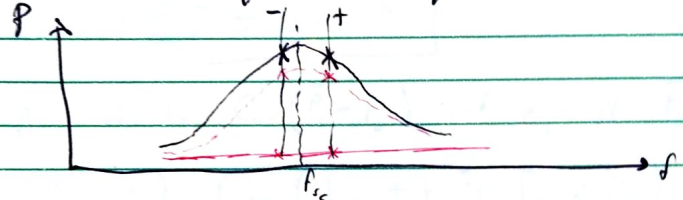

Center frequency of each spectrum is set to $f_p/2$ which is the symmetry center for signal and idler modes coming out of the JPA.  Due to this mixing nature of JPA, the left and right hand sides of each spectrum bin will have a certain degree of correlation.  In order to quantify this effect, I will model the observed spectra with a component that has its sidebands correlated($ P_C $) and a component with no correlation ($ P_U $):

$$
\overline{P_O} = \overline{P_C} + \overline{P_U}
$$

Note that this definition is done such that the following statements hold:

\begin{align}
Cov(\overline{P_{O+}}, \overline{P_{O-}}) =& Cov(\overline{P_{C+}}, \overline{P_{C-}}) \\
Var(\overline{P_O}) = \overline{\sigma_O}^2 =& \overline{\sigma_C}^2 + \overline{\sigma_U}^2
\end{align}

We can expand the correlated part as such:
$$
\overline{P_{C+}} = \overline{P_{S+}} + C_{+}\overline{P_{S-}}
$$
The $P_{S}$ is the "source" term where the thermal + quantum noise from the system in millikelvin stages is included along with the axion signal if present.  $C$ is the "sideband participation" ratio, derived from the idler and signal gains of the system at the JPA stage.

$$
C = \frac{G_I}{G_J} \approx \frac{G_J-1}{G_J}
$$
In general, C will be a number between 0 and 1.  It is possible for $G_J$ to go below unity, due to unwanted nonlinear effects at the JPA stage.  In such cases, $G_I$ will be undefined.  During the experiment, we do not operate in such regimes, so this is of no concern to us.

We may define a standard normal variate from observations referred as the "normalized power excess":

$$
\delta = \frac{\overline{P_O} - \mu_O}{\overline{\sigma_O}} \, \sim \, \mathcal{N}(0, 1)
$$
where $\sim \, \mathcal{N}(0, 1) $ is used to denote that $\delta$ is a random variable following a standard normal distribution.

This variable can also be stated in terms of the sideband correlated and uncorrelated terms:

$$
\delta = \delta_C + \delta_U
$$

I will introduce the normalized axion signal using the symbol $s_a$.  Using $*$ as a superscript to denote the existence of axion for the particular case:

$$
\delta_{+}^* = \delta_{S+} + C_{+}\delta_{S-} + s_{a+} + C_{+}s_{a-} + \delta_{U+}
$$

Note that in reality $s_a$ itself is a random variable, but since we are assuming weak signal powers its variance will be small compared to the noise components.  Therefore, I will treat $s_a$ as a scalar that shifts the mean of a bin when the axion signal is present.

Consequently:
$$
\delta_{-}^* = \delta_{S-} + C_{-}\delta_{S+} + s_{a-} + C_{-}s_{a+} + \delta_{U-}
$$

It is clear that both sides of the spectrum contains similar information.  We can define a new variable that combines the two sidebands (ß stands for "ss", meaning "sideband sum"):

$$
\delta_ß = \frac{\delta_+ + \delta_-}{\sigma_{ß}}
$$

In the presence of axion (no sign means +):
$$
\delta_ß^* = \delta_ß + \frac{(1+C_-)s_{a+} + (1+C_+)s_{a-}}{\sigma_ß} \approx \delta_ß + \frac{(1+C_+)(s_{a+} + s_{a-})}{\sigma_ß}
$$

For most spectra, the signal will be contained entirely on one side, e.g. s_{a-} = 0.  In such a case, we can see that $\frac{(1+C)}{\sigma_ß}$ is the SNR improvement in comparison to using only one sideband.  We can go further and write a relation for $\sigma_ß$ to make things clearer:

$$
\sigma_ß = \sqrt{Var\left(\delta_+ + \delta_-\right) = Var(\delta_+) + 2 Cov(\delta_+, \delta_-) + Var(\delta_-)} = \sqrt{2(1 + Cov(\delta_+, \delta_-))}
$$

If we consider the case with $C = 1$ and perfect sideband correlation with $\sigma_ß = 2$, there is nothing to gain from introducing $\delta_ß$.  In reality, the correlation is not significantly dominant ($\frac{\sigma_U}{\sigma_C} \neq 0$), albeit still strong.  Note that, I will refrain from attributing $\sigma_U$ completely to the stages after the JPA, even though it may be tempting to do so.  In other words, I will not assume JPA is a perfect noiseless amplifier, and stick to what I can measure.

Using, 
$$
\gamma_C^2 = Cov(\delta_+, \delta_-)
$$

There are two straightforward ways to estimate the covariance term from the dataset:

##### 1. Using Raw Spectra
This is the most direct method for estimation as it uses the raw spectra prior to averaging.  If we expand the covariance term:

\begin{align}
\gamma_C^2 =& Cov(\frac{\overline{P_{O+}} - \mu_{O+}}{\overline{\sigma_{O+}}}, \frac{\overline{P_{O-}} - \mu_{O-}}{\overline{\sigma_{O-}}}) \\
    =& \frac{Cov(\overline{P_{O+}}, \overline{P_{O-}})}{\overline{\sigma_{O+}}\overline{\sigma_{O-}}})\\
    =& \frac{1}{M}\frac{Cov(P_{O+}, P_{O-})}{\overline{\sigma_{O+}}\overline{\sigma_{O-}}})
\end{align}

We can estimate $(\sigma_{O+-}^2)_k = Cov(P_{Ok}, P_{O-k})$ using the sample covariance formula:

$$
\hat{(\sigma_{O+-}^2)_k} = \frac{1}{M-1}
\left(
\sum_{n=1}^M P_{Okn}P_{O-kn} - M \overline{P_{O+}}\overline{P_{O-}}
\right)
$$

where k is an indexer for frequency bins. Note that $\sigma_{O\mp}$ can be estimated from the data using $\mu_{O\mp}/\sqrt{M}$.  For this test dataset, this option is not available.

##### 2. Using Averaged Spectrum
If we assume covariance changes slowly over frequency bins, we can estimate the covariance using consecutive bins of pairs from each side of the spectrum.  We can define a "frequency averaged covariance" centered at frequency $\Delta \nu$ averaged over a frequency window of $\Delta_{c}$:

$$
\hat{\overline{\gamma_C^2}}(\Delta \nu, \Delta_{c}) = \frac{1}{N_c-1}\left(
\sum_{k=q}^l \delta_k \delta_{-k} - l^{-1} \sum_{k,m=q}^l \delta_k \delta_{-m})
\right)
$$
where $N_c = q-l$, $\Delta_c = N_c f_{res}$, and $\Delta \nu = \frac{q+l}{2}f_{res}$.

In [70]:
%%time
fwindow = 1700 * FRES
ds = DS_SBC
nwindow = int(fwindow // FRES)
nbins = ds.dims["dnu"]
totrim = nbins % nwindow
print(f"{totrim:d}/{nwindow:d} of a window will be trimmed.")

FWIN_COV = nwindow * FRES
display(Math(f"\\Delta_c = {FWIN_COV}\\, \\mathrm{{Hz}}"))

ds_s = ds.coarsen(dnu=nwindow, boundary="trim").construct(dnu=["sbin", "segbin"])
ds_s.coords["sbin"] = ds_s.dnu.mean(dim="segbin")

cov_l = []
for f, ds in ds_s.groupby("sbin"):
    print(f"Processing dnu={f} Hz.")
    right = ds.right
    left = ds.left
    cov_l.append(xr.cov(right, left, dim="segbin", ddof=1))

DA_GSQR = xr.concat(cov_l, dim="dnu").rename(sbin="dnu")
DA_GSQR.coords["dnu"].attrs = ds.dnu.attrs.copy()

def _plot(runstep):
    da = DA_GSQR
    da.sel(runstep=runstep).plot(marker="o")

interact(_plot, runstep=rsrange);

1199/1700 of a window will be trimmed.


<IPython.core.display.Math object>

Processing dnu=53218.75 Hz.
Processing dnu=159468.75 Hz.
Processing dnu=265718.75 Hz.
Processing dnu=371968.75 Hz.


interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

CPU times: user 194 ms, sys: 161 ms, total: 356 ms
Wall time: 174 ms


<function __main__._plot(runstep)>

Calculating $ \sigma_ß = \sqrt{2(1 + \gamma_C^2)} $ and using it to estimate $\delta_ß = \frac{\delta_+ + \delta_-}{\sigma_{ß}} $:

In [71]:
da = DA_GSQR
sigma_ss = np.sqrt(2*(1+da)).reindex_like(DS_SBC, method='nearest')

right, left = DS_SBC.right, DS_SBC.left

DA_DELTA_SS = (right + left)/sigma_ss
DA_DELTA_SS.attrs['long_name'] = "$\\delta_ß$"
DA_SIGMA_SS = sigma_ss
DA_SIGMA_SS.attrs['long_name'] = "$\\sigma_ß$"

In [72]:
def _plot(runstep):
    delta = DA_DELTA_SS.sel(runstep=runstep)

    xlabel = f"{delta.dnu.attrs['long_name']} [{delta.dnu.attrs['units']}]"
    ylabel = f"{delta.attrs['long_name']}"
    signoiseplot(
        delta.dnu.data,
        delta.data,
        ylim=(-5, 5),
        figsize=(12, 6),
        xlabel=xlabel,
        ylabel=ylabel,
    )

interact(_plot, runstep=rsrange);

interactive(children=(IntSlider(value=9, description='runstep', max=18), Output()), _dom_classes=('widget-inte…

Looking at the estimated distribution parameters, looks like our estimation of $\sigma_ß$ is sufficiently close to the truth.

### 3.6 Grand Spectrum Construction

#### 3.6.1 Spectrum Quantities of Interest
Decomposing $\delta_ß$:

$$
\delta_ß = X_{0ß} + s_ß
$$
where the first term is the random variable for the null hypothesis and the second term is the signal scaled to make null hypothesis a standard normal variate.

We can further write down $s_ß$ as (frequency dependencies are not shown for clarity):

$$
s_ß = \frac{2\sqrt{M}}{\sigma_ß} \frac{P_{a0} g_ß(\nu_a)}{k_B \Delta_r T_{sys}}
$$
where $P_{a0}$ is the axion signal power and $g_ß(\nu_a)$ is the expected signal distribution, with $\int g_ß(\nu_a; \nu') d\nu' \approx 1$.  Note that I assumed that $f_{sc}$ is close enough to $f_{cav}$ that signal power has symmetry around $f_{sc}$.  It can be shown that:

$$
g_ß(\nu_a; \nu) = \frac{1}{2}\left[(1 + C(2f_{sc} - \nu)) f(\nu) + (1 + C(\nu)) f(2 f_{sc} - \nu)\right]
$$
or using the shorthand notation introduced earlier:

$$
g_ß = \frac{1}{2}\left[(1 + C_-) f_+ + (1 + C_+) f_-\right]
$$

where $f(\nu)$ is the distribution function for the virialized axion boosted to lab frame:
$$
f(\nu) = \frac{2}{\sqrt{\pi}} 
\left(
\sqrt{\frac{3}{2}}\frac{1}{r}\frac{1}{\nu_a \overline{\beta^2}}
\right)
\sinh{
\left(
3r \sqrt{\frac{2(\nu - \nu_a)}{\nu_a \overline{\beta^2}}}
\right)
\exp{
\left(
-\frac{3(\nu - \nu_a)}{\nu_a \overline{\beta^2}} - \frac{3 r^2}{2}
\right)
}
}
$$

While we don't know what exactly the signal power $P_{a0}$ will be, we can make an estimate assuming KSVZ coupling.

Rewriting the relations involving the experimental indexes i and j, spanning runstep and $\Delta_{\nu}$ respectively:

$$
\delta^ß_{ij} = X^{0ß}_{ij} + s^ß_{ij}
$$


$$
s^ß_{ij} = \frac{2\sqrt{M}}{\sigma^ß_{ij}} \frac{P^{a0}_{ij} g^ß_{ij}(\nu_a)}{k_B \Delta_r T^{sys}_{ij}}
$$

Let's suppose that axion exists at some frequency $\nu_a$ . It is infinitely unlikely that it will fall exactly at the center of any measurement bin in our data set.  If $\nu_a$ is in our frequency range, it is likely that the signal will be contained in multiple spectra.

The signal shape has theoretically infinite tail, but for practical purposes we need to cut it at certain frequency $W_g$.

#### 3.6.2 Form Factor Data

Let's get the form factor data to use in signal power estimation:

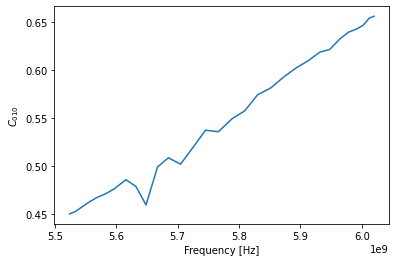

In [73]:
DA_FF = xr.open_dataset(
    "/home/ckutlu/Work/CAPP8TB6G/8TB6G_FF_S1.nc").rename(f='frequency').c
DA_FF.plot()

#### 3.6.3 Expected Signal Power

In [74]:
from scipy import constants as cnst
# Real constants
kB = cnst.Boltzmann
alpha = cnst.fine_structure
pi = np.pi
hbar = cnst.hbar
c = cnst.speed_of_light
mu_0 = cnst.mu_0

G_G_KSVZ = -0.97
LAMBDA = 77.6*(cnst.eV*1.e6)  # 77.6 GeV
RHO = 0.45*(cnst.eV*1e9)/1e-6  # 0.45 GeV/cm^3
BETA_DM = 270e3/c  # avg velocity


def signal_power(freq, fcav, q_l, beta, formfactor, bfield, volume):
    bw = fcav/q_l
    U00 = (G_G_KSVZ*cnst.fine_structure/np.pi)**2
    U01 = ((cnst.hbar*cnst.c)**3)*RHO/(LAMBDA**4)
    U02 = (2*np.pi*fcav/cnst.mu_0)*(bfield**2)*volume
    C0 = formfactor * q_l * beta/(1+beta)
    C1 = 1/(1+(2*(freq-fcav)/bw)**2)
    return U00*U01*U02*C0*C1

FBIN = (DA_DELTA_SS.fsc + DA_DELTA_SS.dnu)
daff = DA_FF.interp(frequency=FBIN).drop_vars('frequency')
DA_SIG_KSVZ = signal_power(FBIN, DS_CAV.fcav, DS_CAV.q_l, DS_CAV.beta, daff, 7.2, 3.1e-3)
display(DA_SIG_KSVZ)

<xarray.DataArray (runstep: 19, dnu: 7999)>
array([[1.39345008e-23, 1.39351871e-23, 1.39358703e-23, ...,
        1.74931735e-24, 1.74892401e-24, 1.74853081e-24],
       [1.39830615e-23, 1.39836758e-23, 1.39842869e-23, ...,
        1.72628635e-24, 1.72589861e-24, 1.72551099e-24],
       [1.39402105e-23, 1.39408537e-23, 1.39414937e-23, ...,
        1.74528547e-24, 1.74489360e-24, 1.74450186e-24],
       ...,
       [1.39283201e-23, 1.39290904e-23, 1.39298575e-23, ...,
        1.75343728e-24, 1.75304183e-24, 1.75264650e-24],
       [1.39452737e-23, 1.39460030e-23, 1.39467291e-23, ...,
        1.74516998e-24, 1.74477679e-24, 1.74438373e-24],
       [1.39819670e-23, 1.39825618e-23, 1.39831534e-23, ...,
        1.72505185e-24, 1.72466467e-24, 1.72427761e-24]])
Coordinates:
  * runstep  (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fsc      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
  * dnu      (dnu) float64 125.0 187.5 250.0 312.5 ... 4.999e+05 4.999e+05 5e+05

#### 3.6.4 Noise Temperature Estimation

Let's use the precomputed noise temperature estimation.  Note that the resolution of that estimation is rather low, to avoid injecting correlations due to interpolation on low-resolution data, I will use forward filling method.  Also, while the noise temperature estimations are not perfectly symmetric, I will approximate it as such and use the average of two sides as one sided noise temperature spectrum.

In [75]:
from groundcontrol.analysis.nt import noise_psd

auxds = get_dataset("AuxTable", False)

# we are way below 100 mK
# noise power will not change more than 1% with ~10 mK difference.
tmean = ((auxds.t_mc2 + auxds.t_cav2)/2).mean().item()
tstd = np.sqrt(auxds.t_mc2.var() + auxds.t_cav2.var()).item()
assert tmean < 50e-3
assert tstd < 3e-3
if tstd == 0:
    print("[WARNING] Temperature variance is 0.  Probably a sampling issue for data from rack temperature controller.")

tn_src = noise_psd(tmean, FBIN)/cnst.Boltzmann

ds = xr.open_dataset(DATAPATH, group="proc/CD10-SUP6/RunNT")[['tn', 'tn_err']].drop_vars(['frequency', 'fbin'])
dss = (ds + ds.assign_coords(dnu=-ds.dnu))/2
# Im dropping tn_err until I properly deal with it.
DS_NT = (dss.reindex_like(DA_SIG_KSVZ, method='ffill') + tn_src).rename(tn='tsys').drop_vars('tn_err') 
display(DS_NT)

[WARNING] Temperature variance is 0.  Probably a sampling issue for data from rack temperature controller.


<xarray.Dataset>
Dimensions:  (runstep: 19, dnu: 7999)
Coordinates:
  * runstep  (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * dnu      (dnu) float64 125.0 187.5 250.0 312.5 ... 4.999e+05 4.999e+05 5e+05
    fsc      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Data variables:
    tsys     (runstep, dnu) float64 0.4313 0.4313 0.4313 ... 0.4549 0.4557

#### 3.6.5 Single Bin SNR Check
First calculate:
$$
R^ß_{ij} = \frac{2\sqrt{M}}{\sigma^ß_{ij}} \frac{P^{a0}_{ij} }{k_B \Delta_r T^{sys}_{ij}}
$$

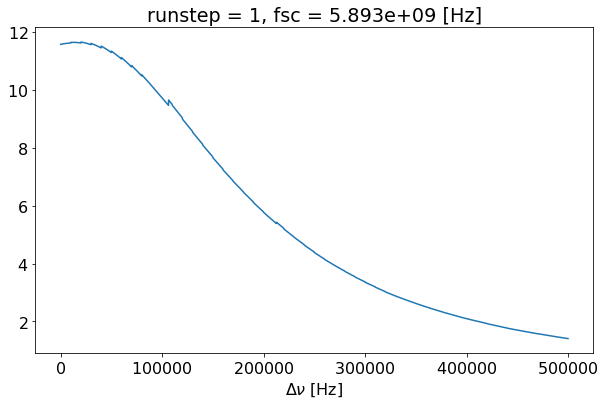

In [76]:
DA_R_SS = (2*np.sqrt(NOBS)/DA_SIGMA_SS)*DA_SIG_KSVZ/(cnst.Boltzmann*FRES*DS_NT.tsys)
DA_R_SS.sel(runstep=1).plot()

We see that there are apparent jumps in the single bin snR spectra.  One can confirm that these are coming from the estimation uncertainties in $\sigma_ß$ and $T_{sys}$.  One way to circumvent issues that may come up when we combine spectrum is to calculate the R within blocks with average estimates "within a block".  This should be fine as long as we keep block span less than 10 kHz.

#### 3.6.6 C-Factor Computation

Let's compute the C factor given by $C=\frac{G_J - 1}{G_J}$

In [77]:
cfact = (DA_GJ-1)/DA_GJ
DA_CFACT_SS = ((cfact + cfact.assign_coords(dnu=-cfact.dnu))/2).interp_like(DA_SIGMA_SS)
display(DA_CFACT_SS)
# DA_CFACT_SS.sel(runstep=0).plot()
# display(DA_CFACT_SS)

<xarray.DataArray 'gj' (runstep: 19, dnu: 7999)>
array([[0.98947166, 0.9894713 , 0.98947094, ..., 0.96908102, 0.96907961,
        0.9690782 ],
       [0.98906925, 0.98906888, 0.98906852, ..., 0.96887526, 0.96887482,
        0.96887437],
       [0.98948209, 0.98948184, 0.98948159, ..., 0.96959183, 0.96959062,
        0.96958941],
       ...,
       [0.98904139, 0.98904136, 0.98904133, ..., 0.96959735, 0.9695962 ,
        0.96959506],
       [0.98915655, 0.98915627, 0.98915599, ..., 0.96973691, 0.96973559,
        0.96973428],
       [0.98942933, 0.98942925, 0.98942917, ..., 0.97007074, 0.97006975,
        0.97006877]])
Coordinates:
    fsc      (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
  * runstep  (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * dnu      (dnu) float64 125.0 187.5 250.0 312.5 ... 4.999e+05 4.999e+05 5e+05

#### 3.6.7 Expected Waveform Data

We have precomputed the values for $h_1$ as defined below:
$$
g^ß_{ij}(\nu_a) \approx \frac{1 + C}{2}h_1(\nu_a; \nu-\nu_a)
$$

In [78]:
DA_WF = xr.open_dataarray(
    "/home/ckutlu/Work/CAPP8TB6G/8TB6G_WFBANK.nc"
).load()  # just in case, load may be necessary
display(DA_WF)


def _plot(nu_a: float, dnu_a: float):
    DA_WF.sel(nu_a=nu_a, dnu_a=dnu_a).plot()


interact(_plot, nu_a=DA_WF.nu_a.data, dnu_a=DA_WF.dnu_a.data);

<xarray.DataArray (nu_a: 4, dnu_a: 201, df: 201)>
array([[[0.00218578, 0.00394535, 0.00503924, ..., 0.0008099 ,
         0.00080939, 0.00080939],
        [0.00218587, 0.00394544, 0.00503934, ..., 0.00083048,
         0.00083048, 0.000831  ],
        [0.00218597, 0.00394554, 0.00503944, ..., 0.00085208,
         0.00085262, 0.00085368],
        ...,
        [0.00806679, 0.00898151, 0.00898151, ..., 0.00042058,
         0.0004099 , 0.00039949],
        [0.00612814, 0.00612814, 0.00503768, ..., 0.00042058,
         0.0004099 , 0.00039949],
        [0.00218431, 0.00394383, 0.00503768, ..., 0.00042058,
         0.0004099 , 0.00039949]],

       [[0.00215813, 0.00389574, 0.00497644, ..., 0.00083904,
         0.00083852, 0.00083852],
        [0.00215823, 0.00389584, 0.00497654, ..., 0.00086013,
         0.00086013, 0.00086065],
        [0.00215834, 0.00389595, 0.00497666, ..., 0.00088226,
         0.0008828 , 0.00088387],
...
        [0.00786772, 0.00875843, 0.00875843, ..., 0.00045067,
         0.00043948, 0.00042855],
        [0.00597466, 0.00597466, 0.00491307, ..., 0.00045067,
         0.00043948, 0.00042855],
        [0.00212931, 0.00384536, 0.00491307, ..., 0.00045067,
         0.00043948, 0.00042855]],

       [[0.0021046 , 0.00379964, 0.00485473, ..., 0.00089843,
         0.0008979 , 0.0008979 ],
        [0.00210472, 0.00379975, 0.00485486, ..., 0.00092053,
         0.00092053, 0.00092107],
        [0.00210484, 0.00379988, 0.00485499, ..., 0.00094371,
         0.00094426, 0.00094535],
        ...,
        [0.00777123, 0.00865033, 0.00865033, ..., 0.00046599,
         0.00045454, 0.00044336],
        [0.00590031, 0.00590031, 0.00485268, ..., 0.00046599,
         0.00045454, 0.00044336],
        [0.00210266, 0.00379764, 0.00485268, ..., 0.00046599,
         0.00045454, 0.00044336]]])
Coordinates:
  * dnu_a    (dnu_a) float64 -1.25e+04 -1.244e+04 -1.238e+04 ... -62.5 0.0
  * df       (df) float64 0.0 62.5 125.0 187.5 ... 1.238e+04 1.244e+04 1.25e+04
  * nu_a     (nu_a) float64 5.8e+09 5.85e+09 5.9e+09 5.95e+09
Attributes:
    long_name:    $h_1$
    comment:      Naive waveform bank generated without window convolutions.
    source:       Axion Model Waveforms.ipynb
    title:        8TB6G_WFBANK
    Conventions:  CAPP-HED-0.1
    institution:  IBS-CAPP

interactive(children=(Dropdown(description='nu_a', options=(5800000000.0, 5850000000.0, 5900000000.0, 59500000…

#### 3.6.7 Grand Dataset Construction
This is all the relevant dataarrays collect in one big commonly indexed dataset.  Not to be confused with grandspectrum which will be the *result* of the analysis on this dataset.

In [79]:
# DA_SIGMA_SS
# DA_SIG_KSVZ
# DS_NT.tsys
# DA_CFACT_SS

DS_2C = xr.Dataset(
    {
        "delta_ss": DA_DELTA_SS,
        "sigma_ss": DA_SIGMA_SS,
        "p_a0": DA_SIG_KSVZ,
        "tsys": DS_NT.tsys,
        "cfact": DA_CFACT_SS,
    }
).pipe(lambda ds: xr.merge([ds.assign_coords(dnu=-ds.dnu), ds]))

display(DS_2C)
# DA_R_SS = (2*np.sqrt(NOBS)/DA_SIGMA_SS)*DA_SIG_KSVZ/(cnst.Boltzmann*FRES*DS_NT.tsys)

<xarray.Dataset>
Dimensions:   (dnu: 15998, runstep: 19)
Coordinates:
  * dnu       (dnu) float64 -5e+05 -4.999e+05 -4.999e+05 ... 4.999e+05 5e+05
  * runstep   (runstep) uint64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    fsc       (runstep) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Data variables:
    delta_ss  (runstep, dnu) float64 -0.7152 2.563 0.7596 ... -1.844 0.4528
    sigma_ss  (dnu, runstep) float64 1.826 1.854 1.822 ... 1.776 1.831 1.786
    p_a0      (runstep, dnu) float64 1.749e-24 1.749e-24 ... 1.725e-24 1.724e-24
    tsys      (runstep, dnu) float64 0.4576 0.4561 0.4561 ... 0.4549 0.4557
    cfact     (runstep, dnu) float64 0.9691 0.9691 0.9691 ... 0.9701 0.9701

We need to collect data in overlapping windows accross frequency bins.  There is no ready-made method for this, so I am gonna use groupby operations with incremental bins.  The windows will have 12500 Hz width, and will be slided by 62.5 Hz each time.

In [80]:
import pandas as pd

LMAX = 201
FRES = 62.5

stacked = DS_2C.stack(aux=["runstep", "dnu"])
fbin = stacked.fsc + stacked.dnu
stacked.coords['fbin'] = fbin
fmin, fmax = fbin.min(), fbin.max()
fwin = FRES*(LMAX - 1)
BLOCKBINS = np.arange(fmin, fmax, fwin)
BLKMAT = np.add.outer(np.arange(LMAX-1)*FRES, BLOCKBINS)
assert len(np.unique(BLKMAT)) == BLKMAT.size  # no duplicate bins

# For batch processing, this for loop should not be constructed all at once
# to avoid memory problems.  Here, data size is relatively small.
DS_SLW_L = []
for bbinarr in BLKMAT:
    nua = pd.cut(fbin, bbinarr, labels=bbinarr[:-1])
    # nua will contain NaN for values that dont belong to any bin
    DS_SLW_L.append(
        stacked
        .pipe(lambda ds: ds.assign(nu_a=("aux", nua)))
        .dropna(dim='aux', subset=['nu_a']) # remove nomembers
        .set_coords('nu_a')
        .pipe(lambda ds: ds.assign_coords(dnu_a=ds.nu_a - ds.fsc, df=ds.fbin - ds.nu_a))
        .set_index(aux=["nu_a", "dnu_a", "df"])
    )
display(DS_SLW_L[0])

<xarray.Dataset>
Dimensions:   (aux: 303701)
Coordinates:
    fsc       (aux) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
  * aux       (aux) MultiIndex
  - nu_a      (aux) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
  - dnu_a     (aux) float64 -5.077e+05 -5.077e+05 ... 4.969e+05 4.969e+05
  - df        (aux) float64 7.7e+03 7.762e+03 7.825e+03 ... 3.038e+03 3.1e+03
    fbin      (aux) float64 5.893e+09 5.893e+09 ... 5.893e+09 5.893e+09
Data variables:
    delta_ss  (aux) float64 -0.7152 2.563 0.7596 ... 0.05067 -1.844 0.4528
    sigma_ss  (aux) float64 1.826 1.826 1.826 1.826 ... 1.786 1.786 1.786 1.786
    p_a0      (aux) float64 1.749e-24 1.749e-24 ... 1.725e-24 1.724e-24
    tsys      (aux) float64 0.4576 0.4561 0.4561 0.4561 ... 0.4549 0.4549 0.4557
    cfact     (aux) float64 0.9691 0.9691 0.9691 0.9691 ... 0.9701 0.9701 0.9701

$$
\delta^ß_{ij} = X^{0ß}_{ij} + s^ß_{ij}
$$


$$
s^ß_{ij} = R^ß_{ij}\frac{(1+C_{ij})}{2}h^1_{ij}(\nu_a)
$$

$$
R^ß_{ij} = \frac{2\sqrt{M}}{\sigma^ß_{ij}} \frac{P^{a0}_{ij} }{k_B \Delta_r T^{sys}_{ij}}
$$

Let's do the computation for one window list first:

In [81]:
# We are gonna unstack the dataset, which will be memory inefficient.
# Therefore I will do it in batches.
ds = DS_SLW_L[0]

nuarr = np.unique(ds.nu_a)
numin, numax = nuarr.min(), nuarr.max()

NHT = len(nuarr)
NBATCHNOM = 10
MINELEM = 10
MAXELEM = 100

NBATCH = min(NHT//MINELEM, max(NBATCHNOM, NHT//MAXELEM))
nubins = np.linspace(numin - FRES/2, numax + FRES/2, NBATCH)

print(f"Number of elements = {NHT}")
print(f"Number of computational groups <= {NBATCH}")
print(f"Number of element per group <= {NHT//NBATCH + 1}")

grpd = ds.groupby_bins('nu_a', nubins)

# Sanity check to see all the bins in the dataset are there
assert grpd.count().sum(dim='nu_a_bins') == ds.sizes['aux']

r_g_l = []
delta_g_l = []
for i, (label, grp) in enumerate(grpd):
    print(f"Processing {label}.")
    ds = grp.unstack()
    wf = DA_WF.reindex_like(ds, method='nearest').compute()
    sigma_ss = ds.sigma_ss.mean(dim='df', skipna=True).broadcast_like(ds)
    tsys = ds.tsys.mean(dim='df', skipna=True).broadcast_like(ds)
    shapefactor = (1+ds.cfact)*wf/2
    r_ss = (2*np.sqrt(NOBS)/sigma_ss)*ds.p_a0/(cnst.Boltzmann*FRES*tsys)
    nelems = r_ss.count(dim=["dnu_a", "df"])
    r_g = (((r_ss*shapefactor) ** 2).sum(dim=["dnu_a", "df"])).pipe(
        lambda ds: np.sqrt(ds)
    )
    delta = ds.delta_ss
    das_delta = (delta * (r_ss*shapefactor)**2).sum(dim=['dnu_a', 'df'])
    delta_g = das_delta/r_g
    
    r_g_l.append(r_g)
    delta_g_l.append(delta_g)
    

# DA_R_SS = (2*np.sqrt(NOBS)/DA_SIGMA_SS)*DA_SIG_KSVZ/(cnst.Boltzmann*FRES*DS_NT.tsys)

Number of elements = 107
Number of computational groups <= 10
Number of element per group <= 11
Processing (5892621127.083, 5892768356.25].
Processing (5892768356.25, 5892915585.417].
Processing (5892915585.417, 5893062814.583].
Processing (5893062814.583, 5893210043.75].
Processing (5893210043.75, 5893357272.917].
Processing (5893357272.917, 5893504502.083].
Processing (5893504502.083, 5893651731.25].
Processing (5892473897.917, 5892621127.083].
Processing (5892326668.75, 5892473897.917].


In [90]:
DA_R_G = xr.concat(r_g_l, dim='nu_a').sortby('nu_a')

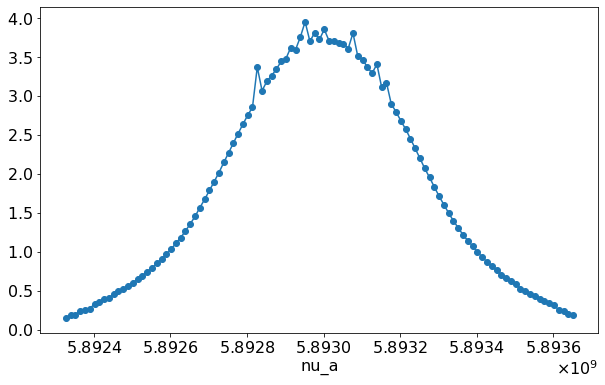

In [91]:
DA_R_G.plot(marker='o')

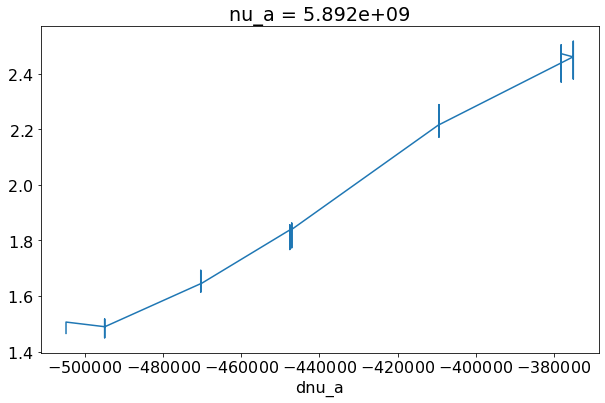

In [84]:
r_ss.isel(nu_a=0).stack(aux=['dnu_a', 'df']).dropna('aux').plot(x='dnu_a')

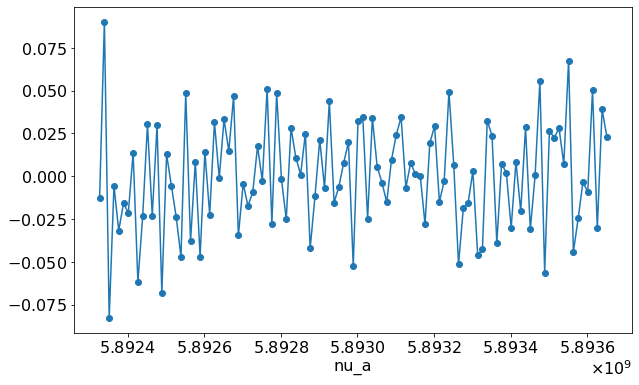

In [89]:
DA_DELTA_G = xr.concat(delta_g_l, dim='nu_a')
(DA_DELTA_G/DA_R_G).sortby('nu_a').plot(marker='o')

In [86]:
wf = DA_WF.reindex_like(ds, method='nearest')
shapefactor = (1+ds.cfact)*wf

In [87]:
ds.count(dim=['dnu_a', 'df'])/200

<xarray.Dataset>
Dimensions:   (nu_a: 12)
Coordinates:
  * nu_a      (nu_a) float64 5.892e+09 5.892e+09 ... 5.892e+09 5.892e+09
Data variables:
    delta_ss  (nu_a) float64 7.61 8.0 6.405 5.37 6.0 ... 2.25 3.0 3.0 1.755 2.0
    sigma_ss  (nu_a) float64 7.61 8.0 6.405 5.37 6.0 ... 2.25 3.0 3.0 1.755 2.0
    p_a0      (nu_a) float64 7.61 8.0 6.405 5.37 6.0 ... 2.25 3.0 3.0 1.755 2.0
    tsys      (nu_a) float64 7.61 8.0 6.405 5.37 6.0 ... 2.25 3.0 3.0 1.755 2.0
    cfact     (nu_a) float64 7.61 8.0 6.405 5.37 6.0 ... 2.25 3.0 3.0 1.755 2.0

In [92]:
NUA = 6
r0 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=0).dropna(dim='df')
r1 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=1).dropna(dim='df')
r2 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=2).dropna(dim='df')
r3 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=3).dropna(dim='df')
r4 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=4).dropna(dim='df')
r5 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=5).dropna(dim='df')
r6 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=6).dropna(dim='df')
r7 = r_ss.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=7).dropna(dim='df')

sh0 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=0).dropna(dim='df')
sh1 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=1).dropna(dim='df')
sh2 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=2).dropna(dim='df')
sh3 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=3).dropna(dim='df')
sh4 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=4).dropna(dim='df')
sh5 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=5).dropna(dim='df')
sh6 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=6).dropna(dim='df')
sh7 = shapefactor.isel(nu_a=NUA).dropna(dim='dnu_a', how='all').isel(dnu_a=7).dropna(dim='df')

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
a = (1+ds.cfact).isel(nu_a=0).dropna(dim='dnu_a', how='all').isel(dnu_a=0).dropna(dim='df')
display(r0.df - shapefactor.df)
#display(shapefactor.df)

### 3.* Test for Stationarity

We can test our power spectrum dataset for stationarity using PowSpect-QACTIVE-MARKER dataset.

This is closely related to what is called a "unit root test":  https://en.wikipedia.org/wiki/Unit_root_test

One example test method is: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

I will leave this work for later.

In [ ]:
pdsm = get_dataset("PowSpect-QACTIVE-MARKER")
da = pdsm.sel(runstep=2).power_w

for i in range(10):
    N = 10000
    combination = np.random.choice(np.arange(pdsm.dims["rep"]), size=N)
    da.sel(rep=combination).plot.hist(bins=50, histtype="step", log=True);